# Data Science Avancées

## <span style='color:green; font-weight: bold;'> Importation des modules, Variables globales, etc </span>

In [1]:
from pathlib import Path
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import _criterion

# import matplotlib.cm as cm

document_name = "classic4"
datasets_path = Path.cwd().parent.parent / "core" / "datasets" / "data"
print(datasets_path)

/home/khaldi/Documents/text-clustering/core/datasets/data


In [2]:
IMAGES_PATH = Path.cwd().parent.parent / "images" / "unsupervised_learning" / f"{document_name}"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## <span style='color:green; font-weight: bold;'>Chargement des données bbc</span>

In [3]:
import pandas as pd

df = pd.read_csv(
    filepath_or_buffer=f'{datasets_path}/{document_name}.csv',
    usecols=['text', 'label']
)
df.shape

(7095, 2)

In [4]:
df_classic4 = df.copy()
df_classic4.head()

,text,label
0,Computer-Aided Analysis and Design of Informat...,cacm
1,Milestones in Cataloging In the case of the pr...,cisi
2,childhood psychosis. a description is given of...,med
3,neonatal hepatitis or familial neonatal obstru...,med
4,Handbook of Comparative Librarianship The firs...,cisi


In [5]:
labels = df_classic4['label'].unique()
labels

array(['cacm', 'cisi', 'med', 'cran'], dtype=object)

In [6]:
list_unique_labels = list(df_classic4['label'].unique())
list_unique_labels

['cacm', 'cisi', 'med', 'cran']

## <span style='color:green; font-weight: bold;'>Analyse exploratoire des données</span>

In [ ]:
# Y-a-t'il des reviews vides?
df_classic4['text'].isnull().sum()

In [ ]:
from collections import Counter

def target2counts(df_doc: pd.DataFrame) -> {str: int}:
    """
    Count number of document per label
    :param df_doc:
    :return:
    """
    targets = list(df_doc.label)
    target_counter = Counter(targets)  # -> dico
    return target_counter

target2counts(df_classic4)

In [ ]:
# Combien de mots dans chaque review ?
word_counts = df_classic4['text'].apply(lambda x: len(x.split())) # pd.series
word_counts.describe()

In [ ]:
_ = plt.boxplot(word_counts.values)
plt.grid(True)
save_fig(f"{document_name}_words_box_plot")
plt.show()


# NB :
# La plupart des reviews ont entre 250 et 475 mots

In [ ]:
_ = plt.boxplot(word_counts.values)
plt.ylim(100, 900)
plt.grid(True)
save_fig(f"{document_name}_words_box_plot_zoomed")
plt.show()

## <span style='color:green; font-weight: bold;'>Nettoyage des données textuelles</span>

On enchaîne dans la fonction *data_preprocessing* les méthodes de nettoyage classiques vues précédemment.

* suppression des tag HTML
* conservation des mots uniquement
* passage en minuscule
* *(tokenization)*
* lemmatisation
* *(réassemblage des reviews)*

In [7]:
from core.preprocessing import Corpus

[nltk_data] Downloading package punkt to /home/khaldi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/khaldi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/khaldi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/khaldi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [8]:
cp = Corpus()
df_classic4 = cp.process_documents(df_classic4)

In [9]:
df_classic4.head()

,text,label
0,computer aided analysis design information sys...,cacm
1,milestone cataloging case present study dr leh...,cisi
2,childhood psychosis description given diagnost...,med
3,neonatal hepatitis familial neonatal obstructi...,med
4,handbook comparative librarianship first part ...,cisi


## <span style='color:green; font-weight: bold;'>Représentation vectorielle de données textuelles</span>

Dans cette partie, nous souhaitons représenter notre corpus de documents en matrice document-terme $\mathbf{X}$ de taille $N\times V$, $N$ étant le nombre de documents et $V$ le nombre total de mots présents dans le vocabulaire. Exemple avec $N=2$ et $V=9$ :
<img src="https://drive.google.com/uc?id=1jdz0lyVCH-7ZfxC5dpj_34f34rBWKs52" width=700>

### 1_ère approche: Bag-Of-Words (BOW)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(min_df=10)
X_docs_bow = bow_vectorizer.fit_transform(df_classic4['text'])
print('X_docs_bow shape: ', X_docs_bow.shape)

# NB:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [ ]:
from numpy import count_nonzero

nb_nonZero = count_nonzero(X_docs_bow.todense())
my_size = float(X_docs_bow.todense().size)
print("Nombre d'éléments non nuls : ", nb_nonZero)
print("Nombre d'éléments : ", my_size)
print("Sparsité : ", 1-(nb_nonZero/my_size))

# NB:
# On a une matrice très sparse!

### 2_ème approche: Pondération matrice *documents x termes* par TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    max_df=0.5, # ignoring terms that appear in more than 50% of the documents (as set by max_df=0.5)
    min_df=5,   # ignoring terms that are not present in at least 5 documents (set by min_df=5)
    stop_words="english",
)
t0 = time()
X_docs_tfidf = tfidf_vectorizer.fit_transform(df_classic4['text'])
print('X_docs_bow shape: ', X_docs_tfidf.shape)
print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_docs_tfidf.shape[0]}, n_features: {X_docs_tfidf.shape[1]}")

In [ ]:
from numpy import count_nonzero

nb_nonZero = count_nonzero(X_docs_tfidf.todense())
my_size = float(X_docs_tfidf.todense().size)
print("Nombre d'éléments non nuls : ", nb_nonZero)
print("Nombre d'éléments : ", my_size)
print("Sparsité : ", 1-(nb_nonZero/my_size))

# NB:
# On a une matrice très sparse!

### 3_ème approche: Word embedding

In [10]:
import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [11]:
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

#### <span style='color:#3390FF; font-weight: bold;'>Word2Vec representation of words</span>

In [12]:
# from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
# from gensim.scripts.glove2word2vec import glove2word2vec

Exécuter les sections suivantes si vous n'avez pas encore chargé et sauvegardé les vectors dans le model dédié

In [13]:
from globals import embeddings_path

# 2nd alternative
word2vec_file = embeddings_path
# we could load keyed vector by specifying that there is no header (dim shape) on top of file.
words_vectors_from_text = KeyedVectors.load_word2vec_format(word2vec_file, binary=False, no_header=True)

# 1st way
# load keyed vector build by own
# word2vec_file = f'{datasets_path}/../glove_model2.txt'
# word2vec_trained_model = KeyedVectors.load_word2vec_format(word2vec_file, binary=False)


# 3rd alt: only if we store data on gensim site_package folder
# words_vectors_from_text = KeyedVectors.load_word2vec_format(datapath('glove.840B.300d.txt'), binary=False, no_header=True)

INFO - 10:38:11: loading projection weights from /home/khaldi/glove.840B.300d.txt
WARNING - 10:39:06: duplicate word '����������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������' in word2vec file, ignoring all but first
INFO - 10:42:05: KeyedVectors lifecycle event {'msg': 'loaded (2196017, 300) matrix of type float32 from /home/khaldi/glove.840B.300d.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2023-05-23T10:42:05.523775', 'gensim': '4.3.1', 'python': '3.10.7 (main, Mar 10 2023, 10:47:39) [GCC 12.2.0]', 'platform': 'Linux-5.19.0-42-generic-x86_64-with-glibc2.36', 'event': 'load_word2vec_format'}


In [14]:
# sauvegarder le model pour une reproductibilité
# words_vectors_from_text.save('word2vec.wordvectors')

In [ ]:
# charger les vecteurs depuis la projection mémoire, partagée par les processus
# words_vectors_from_mapping = KeyedVectors.load('word2vec.wordvectors', mmap='r')
# print(words_vectors_from_mapping)

In [ ]:
# Finding similar words
# The most_similar() function finds the cosine similarity of the given word with
# other words using the word2Vec representations of each word
# result = words_vectors_from_mapping.most_similar('king', topn=5)
# result

In [ ]:
# Calculons: (king - man) + woman = ?
#result = words_vectors_from_mapping.most_similar(
#    positive=['woman', 'king'],
#    negative=['man'],
#    topn=1
#)
#result

In [ ]:
# voir la taille d'un vecteur de mot
# words_vectors_from_mapping['hello'].shape
# model['hello']

In [ ]:
#'hello' in words_vectors_from_mapping.key_to_index.keys()

In [ ]:
#computer_vector = words_vectors_from_mapping['computer']  # Get numpy vector of a word
#computer_vector

Nous allons maintenant récupérer la représentation des mots du modèle

In [ ]:
# import sys
# sys.path.insert(0,"..")

In [60]:
from core.word_embedding import Word2VecVectorizer

# Set a word2vec vectorizer
vectorizer = Word2VecVectorizer(model=words_vectors_from_text)
# Get the sentence embeddings for the train dataset
X_w2v = vectorizer.fit_transform(df_classic4['text'])
print('X_w2v shape: ', X_w2v.shape)

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 1 / 7095
X_w2v shape:  (7095, 300)


#### <span style='color:#3390FF; font-weight: bold;'>GloVe representation of words</span>

Exécuter les sections suivantes si vous n'avez pas encore chargé et sauvegardé les vectors dans le model dédié

###### load glove vector into gensim object

In [ ]:
from globals import embeddings_path

glove_file = embeddings_path

# we could load keyed vector by specifying that
# there is no header (dim shape) on top of file.

glove_words_vectors_from_text = KeyedVectors.load_word2vec_format(
    fname=glove_file,
    binary=False,
    no_header=True
)

# sauvegarder les vecteurs de l'objet gensim dans un fichier
# ---
# glove_words_vectors_from_text.save('glove.wordvectors')

# load
# ---
#glove_words_vectors_from_mapping = KeyedVectors.load('glove.wordvectors', mmap='r')
# print(glove_words_vectors_from_mapping)

###### load gensim object from file

In [ ]:
# updated/new way to do that

# glove_file = f'{datasets_path}/../glove.840B.300d.txt'
# glove_trained_model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

###### save glove object into output file

In [ ]:
# deprecated way

#(_,_) = glove2word2vec(
#    glove_input_file=word2vec_file,
#    word2vec_output_file=tmp_file
#)

Nous allons maintenant récupérer la représentation des mots du modèle

In [ ]:
# Set a word vectorizer
vectorizer = Word2VecVectorizer(model=glove_words_vectors_from_text)
# Get the sentence embeddings for the train dataset
X_glove = vectorizer.fit_transform(df_classic4['text'])
print('X_glove shape: ', X_glove.shape)

# <span style='color:green; font-weight: bold;'>Visualisation through Dimensionality Reduction</span>

In [19]:
from core.plot import points

In [20]:
topics = df_classic4['label'].unique()
color_mapping = {topic: i for i, topic in enumerate(topics)}
topic_colors = [color_mapping[topic] for topic in df_classic4['label']]

## Bac-Of-Words X-matrix
---

### Principal Component Analysis

In [ ]:
from sklearn.decomposition import PCA # ne supporte pas la sparcité

l' **ACP** ne supporte pas les matrices très sparces

In [ ]:
#
# >> pca = PCA(n_components=2)
# >> result = pca.fit_transform(X_docs_bow)

# Scatter plot de la projection
# pyplot.scatter(result[:, 0], result[:, 1])
# dico_terms_idx = result.vocabulary_
# for i, word in enumerate(words):
# 	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
# pyplot.show()

# NB:
# Il est difficile de tirer beaucoup de sens de ce graphique avec un
# corpus aussi minuscule...

Nous allons trouver un autre alternative qui est la technique de dimensionnalité **LSA** connu sous le nom de **TruncatedSVD**

### LSA (aka TruncatedSVD)

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [ ]:
# la svd fait une décomposition sans normalisation.
# nous allons effectuer une normalisation pour optimiser les résultats
n_components = 5
lsa = make_pipeline(
    TruncatedSVD(
        n_components=n_components,
        n_iter=2500,
        random_state=123
    )
    ,
    Normalizer(copy=False)
)

t0 = time()
X_docs_bow_red_lsa = lsa.fit_transform(X_docs_bow)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

In [ ]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_docs_bow_red_lsa[:, nth_dims[0]],
    y=X_docs_bow_red_lsa[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    target_idx_colors=topic_colors,
    s=6,
    t='2D projection (random nb component) of the X (BOW) matrix using Incremental-PCA'
)
save_fig(f"{document_name}_bow_IPCA_2Dplot")

Nous allons tenter d'explorer un peu les résultats, en cherchant nombre d'axes factoriels, nous permettant de préserver un certains ```%centage``` de variance de nos données, dans un but purement représentative.

In [ ]:
# la dimension fitté par le modèle
lsa2 = TruncatedSVD()
lsa2.fit(X_docs_bow)
cumsum2 = np.cumsum(lsa2.explained_variance_ratio_)
d = np.argmax(cumsum2 >= 0.95) + 1  # d equals 1
d

la matrice étant très sparce, il ne faut qu'1 seul dimension, on va essayer de confirmer ce résulat via le graphique en ```coude```


In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum2, linewidth=3)
plt.axis([0, 5, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(10, 0.1), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
#save_fig("explained_variance_plot")
plt.show()

#### $\rightarrow$ vers une approche ICPA

Etant donné que l'on a une matrice très sparse, nous allons explorer une autre approche de PCA qui nous permettra de faire
 en même temps du PCA, de l'imputation. En d'autre terme, nous ferons une imputation à l'aide du PCA

### Incremental PCA

In [ ]:
from sklearn.decomposition import IncrementalPCA

# choix arbitraire
n_components = 2
ipca = IncrementalPCA(
    n_components=n_components,
    batch_size=100
)

X_docs_bow_red_ipca = ipca.fit_transform(X_docs_bow)

In [ ]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_docs_bow_red_ipca[:, nth_dims[0]],
    y=X_docs_bow_red_ipca[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    target_idx_colors=topic_colors,
    s=5,
    t='2D projection (random nb components) of the X (BOW) matrix using Inremental-PCA'
)

In [ ]:
# nombre de composant principal fitté par le model
inc_pca = IncrementalPCA()
inc_pca.fit(X_docs_bow)
inc_pca.n_components_

In [ ]:
# checker combien d'axe factoriel faut-il pour préserver 95% d'inertie de nos jeux de données
inc_pca_ck = IncrementalPCA()
inc_pca_ck.fit(X_docs_bow)
inc_pca_ck_cumsum = np.cumsum(inc_pca_ck.explained_variance_ratio_)
inc_pca_ck_d = np.argmax(inc_pca_ck_cumsum >= 0.95) + 1
inc_pca_ck_d

Essayons de confirmer notre intuition via la méthode ou le graphique du **coude** .

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(inc_pca_ck_cumsum, linewidth=3)
plt.axis([0, 2300, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([inc_pca_ck_d, inc_pca_ck_d], [0, 0.95], "k:")
plt.plot([0, inc_pca_ck_d], [0.95, 0.95], "k:")
plt.plot(inc_pca_ck_d, 0.95, "ko")
plt.annotate("Elbow", xy=(550, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
save_fig("BOW_IPCA_explained_variance_plot")
plt.show()

In [ ]:
# refaisons la projection
inc_pca_ck2 = IncrementalPCA(
    n_components=inc_pca_ck_d,
    batch_size=1660
)
X_docs_bow_red_inc_pca_ck = inc_pca_ck2.fit_transform(X_docs_bow)

In [ ]:
_, ax = plt.subplots()

nth_dims = (1, 3)
points.plot2d(
    ax=ax,
    x=X_docs_bow_red_inc_pca_ck[:, nth_dims[0]],
    y=X_docs_bow_red_inc_pca_ck[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    target_idx_colors=topic_colors,
    t='2D projection (nb components preserving 95% of inertia) of the X (BOW) matrix using Incremental-PCA'
)

### Document embedding using UMAP

In [ ]:
import umap
import umap.plot
# umap.plot requires pandas matplotlib datashader bokeh holoviews scikit-image and colorcet to be installed

In [ ]:
%%time
X_docs_bow_umap_embedding = umap.UMAP(
    n_components=2,
    metric='hellinger'
).fit(X_docs_bow)
X_docs_bow_umap_embedding.embedding_.shape

In [ ]:
# For interactive plotting use
# f = umap.plot.interactive(embedding, labels=dataset.target, hover_data=hover_df, point_size=1)
# show(f)
f = umap.plot.points(X_docs_bow_umap_embedding, labels=df_classic4['label'])

#save_fig("bbc_BOW_UMAP_plot")

## TF-IDF X-matrix
---

In [ ]:
#### La matrice reste sparce, et on ne peut pas appliquer le PCA

#### LSA (aka TruncatedSVD)

In [ ]:
# la svd fait une décomposition sans normalisation.
# nous allons effectuer une normalisation pour optimiser les résultats

n_components=1065  # after fitting
lsa = make_pipeline(TruncatedSVD(n_components=n_components), Normalizer(copy=False))
t0 = time()
X_docs_tfidf_red_lsa = lsa.fit_transform(X_docs_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

In [ ]:
_, ax = plt.subplots()

nth_dims = (1, 2)
points.plot2d(
    ax=ax,
    x=X_docs_tfidf_red_lsa[:, nth_dims[0]],
    y=X_docs_tfidf_red_lsa[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    s=2,
    target_idx_colors=topic_colors,
    t='2D projection (random nb components) of the X (TF-IDF) matrix using LSA'
)

Nous allons tenter d'explorer un peu les résultats, en cherchant nombre d'axes factoriels, nous permettant de préserver le plus de variance de nos données, dans un but purement représentative.

In [ ]:
# la dimension fitté par le modèle
lsa2_tfidf = TruncatedSVD()
lsa2_tfidf.fit(X_docs_tfidf)
cumsum2_tfidf = np.cumsum(lsa2_tfidf.explained_variance_ratio_)
d = np.argmax(cumsum2_tfidf >= 0.95) + 1  # d equals XXX
d

la matrice étant très sparce, il ne faut qu'1 seul dimension, on va essayer de confirmer ce résulat via le graphique en ```coude```


In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum2_tfidf, linewidth=3)
plt.axis([0, 5, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(10, 0.1), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
save_fig(f"{document_name}_TFIDF_LSA_explained_variance_plot")
plt.show()

#### $\rightarrow$ vers une approche ICPAholoviews

Etant donné que l'on a une matrice très sparse, nous allons explorer une autre approche de PCA qui nous
permettra de faire en même temps du PCA, de l'imputation. En d'autre terme, nous ferons une imputation à l'aide du PCA

#### Incremental PCA

In [ ]:
from sklearn.decomposition import IncrementalPCA


# choix arbitraire
n_components = 2
ipca = IncrementalPCA(n_components=n_components, batch_size=100)
X_docs_tfidf_red_ipca = ipca.fit_transform(X_docs_tfidf)

In [ ]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_docs_tfidf_red_ipca[:, nth_dims[0]],
    y=X_docs_tfidf_red_ipca[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    s=1,
    target_idx_colors=topic_colors,
    t='2D projection (random nb components) of the X (TF-IDF) matrix using Incremental-PCA'
)

In [ ]:
# nombre de composant principal fitté par le model
inc_pca_tfidf = IncrementalPCA()
inc_pca_tfidf.fit(X_docs_tfidf)
inc_pca_tfidf.n_components_

In [ ]:
# checker combien d'axe factoriel faut-il pour préserver 95% d'inertie de nos jeux de données
inc_pca_tfidf_ck = IncrementalPCA()
inc_pca_tfidf_ck.fit(X_docs_tfidf)
inc_pca_tfidf_ck_cumsum = np.cumsum(inc_pca_ck.explained_variance_ratio_)
inc_pca_tfidf_ck_d = np.argmax(inc_pca_ck_cumsum >= 0.95) + 1
inc_pca_tfidf_ck_d

Confirmons notre intuition à partir d'un graphique

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(inc_pca_tfidf_ck_cumsum, linewidth=3)
plt.axis([0, 2300, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([inc_pca_tfidf_ck_d, inc_pca_tfidf_ck_d], [0, 0.95], "k:")
plt.plot([0, inc_pca_tfidf_ck_d], [0.95, 0.95], "k:")
plt.plot(inc_pca_tfidf_ck_d, 0.95, "ko")
plt.annotate("Elbow", xy=(550, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
#save_fig("explained_variance_plot")
plt.show()

In [ ]:
X_docs_tfidf.shape

In [ ]:
# refaisons la projection
inc_pca_tfidf_new = IncrementalPCA(
    n_components=inc_pca_ck_d,
    batch_size=1800
)
X_docs_tfidf_red_inc_pca_new = inc_pca_tfidf_new.fit_transform(X_docs_tfidf)
print('X_docs_tfidf_red_inc_pca_new: ', X_docs_tfidf_red_inc_pca_new.shape)

In [ ]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_docs_tfidf_red_inc_pca_new[:, nth_dims[0]],
    y=X_docs_tfidf_red_inc_pca_new[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    s=1,
    target_idx_colors=topic_colors,
    t='2D projection (nb components preserving 95% Inertia) of the X (TF-IDF) matrix using Incremental-PCA'
)

### Document embedding using UMAP

In [ ]:
%%time
X_docs_tfidf_umap_embedding = umap.UMAP(metric='hellinger').fit(X_docs_tfidf)


In [ ]:
# For interactive plotting use
# fig = umap.plot.interactive(tfidf_embedding, labels=dataset.target, hover_data=hover_df, point_size=1)
# show(fig)
_ = umap.plot.points(X_docs_tfidf_umap_embedding, labels=df_classic4['label'])

## <span style='color:#3390FF; font-weight: bold;'>Word2Vec representation of words</span>
---

### Principal Component Analysis (PCA)

In [ ]:
# choix arbitraire
n_components = 2
pca = PCA(n_components=n_components)
X_w2v_pca = pca.fit_transform(X_w2v)

In [ ]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_w2v_pca[:, nth_dims[0]],
    y=X_w2v_pca[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    s=2,
    target_idx_colors=topic_colors,
    t='2D projection (random nb components) of the X (Word2vec) matrix using PCA'
)

In [ ]:
# nombre de composant principal fitté par le model
pca_w2v2 = PCA()
pca_w2v2.fit(X_w2v)
pca_w2v2.n_components_

On peut constater que les données la projection des données ne réduit pas la dimension de ces dernier. Celà indique que les données sont bien représenter dans l'espace vectoriel.

Cela dit, voyons quel nombre de dimension serait le plus adapter pour grader ```95% d'intertie``` de notre jeu de données

In [ ]:
# checker combien d'axe factoriel faut-il pour préserver 95% d'inertie de nos jeux de données
pca_w2v2_ck = PCA()
pca_w2v2_ck.fit(X_w2v)
pca_w2v2_ck_cumsum = np.cumsum(pca_w2v2_ck.explained_variance_ratio_)
pca_w2v2_ck_d = np.argmax(pca_w2v2_ck_cumsum >= 0.95) + 1
pca_w2v2_ck_d # d=130


### Manifold learning

#### $\rightarrow$ vers une approche t-SNE

Nous pouvons tracer les embeddings dans un **espace bidimensionnel** qui peut nous montrer comment les mots sont liés.
Les mots les plus **similaires** devraient être représentés **en groupes**, tandis que les mots non apparentés apparaîtront à une grande distance. <br><br>

Cela nécessite une technique de **réduction de dimension** supplémentaire pour ramener les dimensions à 2 ou 3.
La technique de réduction la plus populaire est elle-même une méthode d'embedding: **t-Distributed Stochastic Neighbor Embedding (t-SNE)**.

t-SNE est une technique de réduction de la dimensionnalité qui convient parfaitement à la visualisation d'ensembles de données de grande dimension.
Il s'agit d'une technique d'apprentissage de type **manifold**, ce qui signifie qu'il tente de faire **correspondre des données de haute dimension à un manifold de plus faible dimension**, créant ainsi un embedding qui tente de maintenir la structure locale des données. Elle est presque exclusivement utilisée pour la visualisation car la sortie est stochastique et elle ne prend pas en charge la transformation de nouvelles données.

In [ ]:
from sklearn.manifold import TSNE                   # final reduction

#### t-Distributed Sémantic Neighbord Embedding (t-SNE)

In [ ]:
tsne = TSNE(
    perplexity=40,
    n_components=2,
    init='pca',
    n_iter=2500,
    random_state=123
)
z = tsne.fit_transform(X_w2v)

In [ ]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=z[:, nth_dims[0]],
    y=z[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    s=2,
    target_idx_colors=topic_colors,
    t='2D projection (random nb components) of the X (Word2Vec) matrix using t-SNE'
)

### Locally Linear Embedding (LLE)

In [95]:
n_neighbors = 100  # neighborhood which is used to recover the locally linear structure
n_components = 2  # number of coordinates for the manifold

In [96]:
from sklearn import manifold

In [97]:
lle_params = {
    "n_neighbors": n_neighbors,
    "n_components": n_components,
    "eigen_solver": "dense",
    "random_state": 123,
}

lle_standard = manifold.LocallyLinearEmbedding(method="standard", **lle_params)
X_w2v_standard_unrolled = lle_standard.fit_transform(X_w2v)

lle_ltsa = manifold.LocallyLinearEmbedding(method="ltsa", **lle_params)
X_w2v_ltsa_unrolled = lle_ltsa.fit_transform(X_w2v)

lle_hessian = manifold.LocallyLinearEmbedding(method="hessian", **lle_params)
X_w2v_hessian_unrolled = lle_hessian.fit_transform(X_w2v)

lle_mod = manifold.LocallyLinearEmbedding(method="modified", **lle_params)
X_w2v_mod_unrolled = lle_mod.fit_transform(X_w2v)

In [98]:
#lle = LocallyLinearEmbedding(n_components=5, n_neighbors=100, random_state=42)
#X_w2v_unrolled = lle.fit_transform(X_w2v)


lle_methods = [
    ("Standard locally linear embedding", X_w2v_standard_unrolled),
    ("Local tangent space alignment", X_w2v_ltsa_unrolled),
    ("Hessian eigenmap", X_w2v_hessian_unrolled),
    ("Modified locally linear embedding", X_w2v_mod_unrolled),
]

classes = [
    'cacm',
    'cisi',
    'med',
    'cran',
    ]

In [ ]:
#fig, ax = plt.subplots()
nth_dims=(0, 1)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("Locally Linear Embeddings", size=16)

for ax, method in zip(axs.flat, lle_methods):
    name, X_red = method
    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=topic_colors,
        cmap='Accent',
        s=4,
        alpha=1
    )
    #handles, labels = scatter.legend_elements()
    #labels = target_names
    #ax.legend(handles, labels, loc="upper left", title="Topic")
    plt.setp(ax, xticks=[], yticks=[])
    cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(5)-0.4)
    cbar.set_ticks(np.arange(4))
    cbar.set_ticklabels(classes, size=10)

    ax.set_title(name, size=12)
save_fig("bbc_W2V_LLEs_plot")
plt.show()
#ax.set_title('2D projection (random nb components) of the X (Word2Vec) matrix using t-SNE')

### Isomap Embedding

In [ ]:
isomap = manifold.Isomap(
    n_neighbors=n_neighbors,
    n_components=n_components,
    p=30)
X_w2v_isomap = isomap.fit_transform(X_w2v)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(
    x=X_w2v_isomap[:, 0],
    y=X_w2v_isomap[:, 1],
    c=topic_colors,
    cmap='Accent',
    s=3,
    alpha=1
)
#handles, labels = scatter.legend_elements()
#labels = target_names
#ax.legend(handles, labels, loc="upper left", title="Topic")
plt.setp(ax, xticks=[], yticks=[])
cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(classes, size=10)
ax.set_title('2D projection (random nb components) of the X (Word2Vec) matrix using \n Isomap Embedding \n', size=16)
save_fig("bbc_W2V_ISOMAP_plot")
plt.show()

### Multidimensional scaling

In [ ]:
md_scaling = manifold.MDS(
    n_components=n_components,
    max_iter=2500,
    n_init=5,
    random_state=123,
    normalized_stress='auto',
)
X_w2v_scaling = md_scaling.fit_transform(X_w2v)


In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))

scatter = ax.scatter(
    x=X_w2v_scaling[:, 0],
    y=X_w2v_scaling[:, 1],
    c=topic_colors,
    cmap='Accent',
    s=3,
    alpha=1
)
plt.setp(ax, xticks=[], yticks=[])
cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(classes, size=10)
ax.set_title('2D projection (random nb components) of the X (Word2Vec) matrix using \n Multidimensional scaling \n', size=16)
save_fig("bbc_W2V_MultiSCALING_plot")
plt.show()

### Spectral embedding for non-linear dimensionality reduction

In [ ]:
spectral4w2v = manifold.SpectralEmbedding(
    n_components=n_components,
    n_neighbors=n_neighbors,
)
X_w2v_spectral = spectral4w2v.fit_transform(X_w2v)


In [ ]:
fig, ax = plt.subplots()

scatter = ax.scatter(
    x=X_w2v_spectral[:, 0],
    y=X_w2v_spectral[:, 1],
    c=topic_colors,
    cmap='Accent',
    s=3,
    alpha=1
)
#handles, labels = scatter.legend_elements()
#labels = target_names
#ax.legend(handles, labels, loc="upper left", title="Topic")
plt.setp(ax, xticks=[], yticks=[])
cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(classes, size=10)
ax.set_title('2D projection (random nb components) of the X (Word2Vec) matrix using \n Spectral Embedding \n ', size=16)
save_fig("bbc_W2V_SpectralEMBEDDING_plot")
plt.show()

### T-distributed Stochastic Neighbor Embedding

In [ ]:
t_sne4w2v = manifold.TSNE(
    n_components=n_components,
    perplexity=30,
    init="random",
    n_iter=2500,
    random_state=123,
)
X_w2v_tsne = t_sne4w2v.fit_transform(X_w2v)

t_sne4w2v_pca = manifold.TSNE(
    n_components=n_components,
    perplexity=30,
    init="pca",
    n_iter=2500,
    random_state=123,
)
X_w2v_tsne_pca = t_sne4w2v_pca.fit_transform(X_w2v)

In [ ]:
tsne_inits = [
    ("t-sne init random", X_w2v_tsne),
    ("t-sne init pca", X_w2v_tsne_pca)
]

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.suptitle("2D projection (random nb components) of the X (Word2Vec) matrix using \n T-NSE \n\n", size=16)

for ax, init in zip(axs.flat, tsne_inits):
    name, X_red = init
    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=topic_colors,
        cmap='Accent',
        s=3,
        alpha=1
    )
    plt.setp(ax, xticks=[], yticks=[])
    cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
    cbar.set_ticks(np.arange(5))
    cbar.set_ticklabels(classes, size=8)
    ax.set_title(name, size=12)
save_fig(f"{document_name}_W2V_TSNE_2Dplot")
plt.show()

On a une bonne représentation des données dans le sens où l'on peut identifier les groupe ou clustering

## <span style='color:#3390FF; font-weight: bold;'>GloVe representation of words</span>
---

### Principal Component Analysis

In [ ]:
import matplotlib.pyplot as plt
# choix arbitraire
n_components = 2
pca = PCA(n_components=n_components)
X_glove_pca = pca.fit_transform(X_glove)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))

scatter = ax.scatter(
    x=X_glove_pca[:, 0],
    y=X_glove_pca[:, 1],
    c=topic_colors,
    cmap='Accent',
    s=3,
    alpha=1
)

plt.setp(ax, xticks=[], yticks=[])
cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(classes, size=10)
ax.set_title('2D projection (random nb components)\n of the X (Glove) matrix using PCA \n ', size=16)
save_fig(f"{document_name}_GLOVE_PCA_2Dplot")
plt.show()

#### $\rightarrow$ vers une approche T-SNE

In [ ]:
t_sne4glove = TSNE(
    perplexity=40,
    n_components=2,
    init='pca',
    n_iter=2500,
    random_state=123
)
reduced_glove_tsne = t_sne4glove.fit_transform(X_glove)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))

scatter = ax.scatter(
    x=reduced_glove_tsne[:, 0],
    y=reduced_glove_tsne[:, 1],
    c=topic_colors,
    cmap='Accent',
    s=3,
    alpha=1
)

plt.setp(ax, xticks=[], yticks=[])
cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(classes, size=10)
ax.set_title('2D projection (random nb components)\n of the X (Glove) matrix using t-SNE \n', size=16)
save_fig(f"{document_name}_GLOVE_TSNE_2Dplot")
plt.show()

# <span style='color:green; font-weight: bold;'>Preparing Data frame For machine learning</span>

#### $\rightarrow$ dataframe
- Transformons $\mathbf{X}$ en dataframe où chaque ligne correspond à un document (ID en index) et chaque colonne correspond à un mot du vocabulaire (les mots en colonne).

In [ ]:
# df_words = pd.DataFrame(
#    data = X,
#    columns = vocab,
#    index = df_text.index
#)
# df_words

# X_docs_bow => bow original (sparce) => not pca
# X_docs_bow_red_lsa => lsa reducted
# X_docs_bow_red_ipca => ipca reducted

# X_docs_tfidf => ifidf original (sparce) => not pca
# X_docs_tfidf_lsa => lsa reduced
# X_docs_tfidf_red_ipca => ipca reduced

In [ ]:
df_words_bow = pd.DataFrame(
    data = X_docs_bow.toarray(),
    index = df_classic4.index,
    columns = bow_vectorizer.get_feature_names_out()
)
df_words_bow.head()


In [ ]:
df_words_tfidf = pd.DataFrame(
    data = X_docs_tfidf.toarray(),
    index = df_classic4.index,
    columns = tfidf_vectorizer.get_feature_names_out()
)
df_words_tfidf.head()


#### $\rightarrow$ dataframe(words-label)

- Jointure entre le dataframe obtenu et la colonne [topic].
- Faire le même nuage de points, cette fois-ci en coloriant les points par rapport à la thématique (colonne TOPIC).

In [ ]:
df_bow = df_words_bow.merge(
    right = df_classic4.label,
    left_index = True,
    right_index=True
)
df_bow.head()

In [ ]:
df_tfidf = df_words_tfidf.merge(
    right = df_classic4.label,
    left_index = True,
    right_index=True
)
df_tfidf.head()

## Quantifying the quality of clustering results

- homogeneity, which quantifies how much clusters contain only members of a single class;

- completeness, which quantifies how much members of a given class are assigned to the same clusters;

- V-measure, the harmonic mean of completeness and homogeneity;

- Rand-Index, which measures how frequently pairs of data points are grouped consistently according to the result of the clustering algorithm and the ground truth class assignment;

- Adjusted Rand-Index, a chance-adjusted Rand-Index such that random cluster assignment have an ARI of 0.0 in expectation.



In [21]:
from collections import defaultdict
from sklearn import metrics
from time import time
from time import sleep

evaluations = []
evaluations_std = []

scores = defaultdict(list)

labels = topic_colors

def evaluate(labels_, X, name=None, metric=None, dset=None, train_times=None):
    scores["Homogeneity"].append(metrics.homogeneity_score(labels, labels_))
    scores["Completeness"].append(metrics.completeness_score(labels, labels_))
    scores["V-measure"].append(metrics.v_measure_score(labels, labels_))
    scores["Rand index"].append(
        metrics.rand_score(labels, labels_)
    )
    scores["ARI"].append(
        metrics.adjusted_rand_score(labels, labels_)
    )
    scores["MI"].append(
        metrics.mutual_info_score(labels, labels_)
    )
    scores["NMI"].append(
        metrics.normalized_mutual_info_score(labels, labels_)
    )
    scores["Silhouette Coefficient"].append(
        metrics.silhouette_score(X, labels_, sample_size=2000)
    )

    evaluation = {
        "dset": dset,
        "estimator": name,
        "metric": metric,
        "train_time": train_times,
    }
    evaluation_std = {
        "dset": dset, # origin or reduced
        "estimator": name,
        "metric": metric,
        "train_time": train_times,
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

def fit_and_evaluate(km, X, name=None, metric=None, dset=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    for seed in range(n_runs):

        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Rand index"].append(
            metrics.rand_score(labels, km.labels_)
        )
        scores["ARI"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["MI"].append(
            metrics.mutual_info_score(labels, km.labels_)
        )
        scores["NMI"].append(
            metrics.normalized_mutual_info_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)
    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")

    evaluation = {
        "dset": dset,
        "estimator": name,
        "metric": metric,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "dset": dset, # origin or reduced
        "estimator": name,
        "metric": metric,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

# <span style='color:green; font-weight: bold;'> Approche Tandem : Réduction de la dimension à laquelle est ajoutée ensuite une tâche de clustering </span>
---

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

import umap
import hdbscan # > sudo apt-get install python3.10-dev before

import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

##  <span style='color:#F9A861; font-weight: bold;'> DONNEES ORIGINALES </span>

In [23]:
X_w2v.shape # wo labels

(7095, 300)

In [24]:
%%time
w2v_umap_emb_irnd = umap.UMAP(
    metric='cosine',
    random_state=123,
    init='random'
).fit_transform(X_w2v)

w2v_umap_emb_ispt = umap.UMAP(
    metric='cosine',
    random_state=123,
    init='spectral'
).fit_transform(X_w2v)

CPU times: user 31.4 s, sys: 2.49 s, total: 33.9 s
Wall time: 29 s


In [25]:
print(w2v_umap_emb_irnd.shape)
print(w2v_umap_emb_ispt.shape)

(7095, 2)
(7095, 2)


In [26]:
umap_methods = [
    ("UMAP metric=cosine, init=random", w2v_umap_emb_irnd),
    ("UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt)
]

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.suptitle("2D projection of the X (W2V) matrix using \n UMAP Embedding \n", size=12)

for ax, method in zip(axs.flat, umap_methods):
    name, X_red = method
    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=topic_colors,
        cmap='Accent',
        s=0.1,
        alpha=1
    )
    plt.setp(ax, xticks=[], yticks=[])
    cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
    cbar.set_ticks(np.arange(5))
    cbar.set_ticklabels(classes, size=10)
    ax.set_title(name, size=11)
save_fig("classic4_W2V_UMAP_2Dplot")
plt.show()

##### <span style='color:#3390FF; font-weight: bold;'> K-Means </span>

In [27]:
km_w2v = cluster.KMeans(
    n_clusters=5,
    n_init=10,
    max_iter=300,
    tol=1e-04,
    init='random',
    random_state=123
)
km_fit_w2v = km_w2v.fit(X_w2v)
km_lab_w2v = km_w2v.fit_predict(X_w2v)

In [ ]:
umap_methods = [
    ('o1', "UMAP metric=cosine, init=random", w2v_umap_emb_irnd, topic_colors, km_w2v.cluster_centers_),
    ('c1', "Check Clustering - UMAP metric=cosine, init=random", w2v_umap_emb_irnd, km_lab_w2v, km_w2v.cluster_centers_),
    ('o2', "UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, topic_colors, km_w2v.cluster_centers_),
    ('c2', "Check Clustering UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, km_lab_w2v, km_w2v.cluster_centers_)
]

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("2D projection of the X (W2V) matrix using \n UMAP Embedding \n", size=12)

for ax, method in zip(axs.flat, umap_methods):
    tag, name, X_red, cmap, centers = method
    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=cmap,
        cmap='Accent',
        s=0.1
    )

    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    if tag not in ['c1', 'c2']:
        cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
        cbar.set_ticks(np.arange(5))
        cbar.set_ticklabels(classes, size=10)
    ax.set_title(name, size=11)
save_fig(f"{document_name}_W2V_ORIGNINAL_VS_KMEANS_CULSTERING_UMAP_2Dplot")
plt.show()

###### $\rightarrow$ Model evaluations

In [28]:
fit_and_evaluate(
    km_w2v, # model or estimator
    X_w2v, # matrix original
    name="k-means",
    dset=f"{document_name}-w2v"
)

clustering done in 0.77 ± 0.81 s 
Homogeneity: 0.705 ± 0.000
Completeness: 0.578 ± 0.000
V-measure: 0.635 ± 0.000
Rand index: 0.810 ± 0.000
ARI: 0.512 ± 0.000
MI: 0.906 ± 0.001
NMI: 0.635 ± 0.000
Silhouette Coefficient: 0.115 ± 0.002


In [ ]:
# Pourcentage of variance or distortion
print(f'Distortion: {km_w2v.inertia_:.2f}')


###### $\rightarrow$ Elbow method to Estimate number of clusters needs


In [ ]:
kmeans_per_k =\
    [cluster.KMeans(
    n_clusters=k,
    init='random',
    n_init=10,
    tol=1e-04,
    max_iter=300,
    random_state=0
    ).fit(X_w2v)
    for k in range(1, 11)]

In [ ]:
inertias = [model.inertia_ for model in kmeans_per_k]

In [ ]:
plt.plot(range(1,11), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.grid()
save_fig(f"{document_name}_W2V_BEST_NB_CLUST_DISTORTION_Line_plot")
plt.show()

###### $\rightarrow$ Silhouette method to Estimate number of clusters needs


In [ ]:
silhouette_scores = [metrics.silhouette_score(X_w2v, model.labels_)
                     for model in kmeans_per_k[1:]]

In [ ]:
plt.plot(range(2,11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.tight_layout()
save_fig(f"{document_name}_W2V_BEST_NB_CLUST_SILHOUETTE_SCORE_Line_plot")
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X_w2v, y_pred)

    padding = len(X_w2v) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

save_fig(f"{document_name}_KMEANS++_silhouette_analysis_plot")
plt.show()

##### <span style='color:#3390FF; font-weight: bold;'> K-Means++ </span>

In [29]:
kmpp_w2v = cluster.KMeans(
    n_clusters=5,
    n_init=10,
    init='k-means++',
    max_iter=300,
    tol=1e-04,
    random_state=0
)

kmpp_lab_w2v = kmpp_w2v.fit_predict(X_w2v)

In [ ]:
umap_methods = [
    ('o1', "UMAP metric=cosine, init=random", w2v_umap_emb_irnd, topic_colors),
    ('c1', "Check K-mean++ Clustering \n UMAP metric=cosine, init=random", w2v_umap_emb_irnd, kmpp_lab_w2v),
    ('o2', "UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, topic_colors),
    ('c2', "Check K-mean++ Clustering \n UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, kmpp_lab_w2v)
]

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("2D projection of the X (W2V) matrix using \n UMAP Embedding \n", size=10)

for ax, method in zip(axs.flat, umap_methods):
    tag, name, X_red, cmap = method
    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=cmap,
        cmap='Accent',
        s=0.1
    )
    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    if tag not in ['c1', 'c2']:
        cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
        cbar.set_ticks(np.arange(5))
        cbar.set_ticklabels(classes, size=8)
    ax.set_title(name, size=11)
save_fig(f"{document_name}_W2V_ORIGINAL_VS_KMEANS++_CLUSTERING_2Dplot")
plt.show()

###### $\rightarrow$ Model evaluations

In [30]:
fit_and_evaluate(
    kmpp_w2v, # model
    X_w2v, # matrix original
    name="k-means++",
    metric=None,
    dset=f"{document_name}-w2v"
)

clustering done in 3.05 ± 2.83 s 
Homogeneity: 0.705 ± 0.000
Completeness: 0.578 ± 0.000
V-measure: 0.635 ± 0.000
Rand index: 0.810 ± 0.000
ARI: 0.512 ± 0.000
MI: 0.905 ± 0.001
NMI: 0.635 ± 0.000
Silhouette Coefficient: 0.115 ± 0.002


In [ ]:
# Pourcentage of variance or distortion
print(f'Distortion: {kmpp_w2v.inertia_:.2f}')

In [ ]:
kmeanspp_per_k = \
    [cluster.KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=10,
        tol=1e-04,
        max_iter=300,
        random_state=0
    ).fit(X_w2v)
     for k in range(1, 11)]

In [ ]:
inertias = [model.inertia_ for model in kmeanspp_per_k]

###### $\rightarrow$ Elbow method to Estimate number of clusters needs

In [ ]:
plt.plot(range(1,11), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.grid()
save_fig(f"{document_name}_W2V_KMEANSPP_BEST_NB_CLUST_DISTORTION_Line_plot")
plt.show()

###### $\rightarrow$  silhouette diagram

In [ ]:

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X_w2v, y_pred)

    padding = len(X_w2v) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

save_fig(f"{document_name}_KMEANS++_silhouette_analysis_plot")
plt.show()

As you can see, ***k = 5***, looks like the best option here, as all clusters are roughly the same size,
and they all cross the dashed line, which represents the mean silhouette score.

###### $\rightarrow$  Clustering evaluation summary¶


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()
######

##### <span style='color:#3390FF; font-weight: bold;'> Kmedoids </span>

In [31]:
from sklearn_extra.cluster import KMedoids, CLARA

In [32]:
kmd_w2v_cos = KMedoids(
    metric="cosine",
    n_clusters=5,
    random_state=123,
    max_iter=300
)

kmd_w2v_mnt = KMedoids(
    metric="manhattan",
    n_clusters=5,
    random_state=123,
    max_iter=300
)

clr_w2v_cos = CLARA(
    metric="cosine",
    n_clusters=5,
    init="heuristic",
    n_sampling=250,
    random_state=123
)

clr_w2v_mnt = CLARA(
    metric="manhattan",
    n_clusters=5,
    init="heuristic",
    n_sampling=250,
    random_state=123
)

clustering_algorithms_metrics = [
    ('kcos', "K-Medoid metric=cosine \n UMAP metric=cosine, init=random", kmd_w2v_cos),
    ('kmnt', "K-Medoid metric=manathan \n UMAP metric=cosine, init=random", kmd_w2v_mnt),
    ('rcos', "CLARA metric=cosine \n UMAP metric=cosine, init=random", clr_w2v_cos),
    ('rmnt', "CLARA metric=manathan \nUMAP metric=cosine, init=spectral", clr_w2v_mnt),
]

In [ ]:
umap_mth = [
    ('o1', "UMAP metric=cosine", w2v_umap_emb_irnd, topic_colors),
    ('kc', "KMenoids metric=cosine", w2v_umap_emb_irnd, kmpp_lab_w2v),
    ('km', "KMenoids metric=manhattan", w2v_umap_emb_irnd, kmpp_lab_w2v),
]

umap_mth_spt = [
    ('o2', "UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, topic_colors),
    ('o2', "UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, topic_colors),
    ('o2', "UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, topic_colors),
]

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.suptitle("2D projection of the X (W2V) matrix using \n UMAP Embedding \n", size=12)

umap_init = 'random' #  ou 'spectral'
for ax, algorithm in zip(axs.flat, clustering_algorithms_metrics):
    tag, name, model = algorithm

    # on entraine les modèles
    model.fit(X_w2v)

    # dépendamment de l'implémentation, on peut avoir des attributs labels_ ou non
    if hasattr(model, "labels_"):
        y_pred = model.labels_.astype(int)
    else:
        y_pred = model.predict(X_w2v)

    # select reduction umap method
    X_red = w2v_umap_emb_irnd if umap_init == 'random' else w2v_umap_emb_ispt

    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=y_pred,
        cmap='Accent',
        s=1
    )
    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    ax.set_title(name, size=11)
save_fig(f"{document_name}_KMENOID_VS_CLARA_RANDOM_INIT_CLUSTERING_2Dplot")
plt.show()

In [33]:
fit_and_evaluate(
    kmd_w2v_cos, # model
    X_w2v, # matrix original
    name="kmenoid-cos",
    metric="cosine",
    dset=f"{document_name}-w2v"
)

clustering done in 1.02 ± 0.06 s 
Homogeneity: 0.691 ± 0.019
Completeness: 0.572 ± 0.008
V-measure: 0.626 ± 0.013
Rand index: 0.798 ± 0.017
ARI: 0.485 ± 0.038
MI: 0.888 ± 0.024
NMI: 0.626 ± 0.013
Silhouette Coefficient: 0.118 ± 0.004


In [ ]:
fit_and_evaluate(
    kmd_w2v_mnt, # model
    X_w2v, # matrix original
    name="kmenoid-mnt",
    metric="manhattan",
    dset=f"{document_name}-w2v"
)

In [ ]:
# Pourcentage of variance or distortion
print(f'Distortion: {kmd_w2v_cos.inertia_:.2f}')
# Pourcentage of variance or distortion
print(f'Distortion: {kmd_w2v_mnt.inertia_:.2f}')

In [ ]:
kmenoid_cos_per_k = \
    [KMedoids(
        metric="cosine",
        n_clusters=k,
        random_state=123,
        max_iter=300
    ).fit(X_w2v)
     for k in range(1, 11)]

In [ ]:
kmenoid_mnt_per_k = \
    [KMedoids(
        metric="manhattan",
        n_clusters=k,
        random_state=123,
        max_iter=300
    ).fit(X_w2v)
     for k in range(1, 11)]

In [ ]:
inertias_kmd_cos = [model.inertia_ for model in kmenoid_cos_per_k]
inertias_kmd_mnt = [model.inertia_ for model in kmenoid_mnt_per_k]
silhouette_scores_cos = [metrics.silhouette_score(X_w2v, model.labels_)
                     for model in kmenoid_cos_per_k[1:]]
silhouette_scores_mnt = [metrics.silhouette_score(X_w2v, model.labels_)
                     for model in kmenoid_mnt_per_k[1:]]

###### $\rightarrow$ Elbow method to Estimate number of clusters needs

In [ ]:
nbcluster_choice_methods = [
    ("Elbow method - cos", range(1,11), inertias_kmd_cos, "Number of clusters", "Distortion"),
    ("Silhouette method - cos", range(2,11), silhouette_scores_cos, "Number of clusters", "Silhouette score"),
    ("Elbow method - mnt", range(1,11), inertias_kmd_mnt, "Number of clusters", "Distortion"),
    ("Silhouette method - mnt ", range(2,11), silhouette_scores_mnt, "Number of clusters", "Silhouette score")
]

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("nb clust checking checkout", size=16)

for ax, nbclust in zip(axs.flat, nbcluster_choice_methods):
    name, x, inertias, xlab, ylab = nbclust
    plot = ax.plot(x, inertias, marker='o')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(name, size=12)
    ax.grid()
plt.tight_layout()
save_fig(f"{document_name}_W2V_KMENOID_BEST_NB_CLUST_SILHOUETTE_SCORE_Line_plot")
plt.show()

##### <span style='color:#3390FF; font-weight: bold;'> Sphérical Kmean </span>

In [38]:
from coclust.clustering.spherical_kmeans import SphericalKmeans
skm = SphericalKmeans(
    n_clusters=5,
    n_init=10,
    tol=1e-4,
    max_iter=300
)

In [66]:
np.where(~X_w2v.any(axis=1)) #row 2161 is Zero-valued rows, we add a epsilon for this row

(array([2161]),)

In [67]:
X_w2v[2161,:]=X_w2v[2161,:] + 10**-2

In [68]:
t0 = time()
skm.fit(X_w2v)
t = time() - t0

 == New init == 
iteration: 0
5786.512951878674
iteration: 1
6156.233695643557
iteration: 2
6231.932381598465
iteration: 3
6241.028910317434
iteration: 4
6243.419574410599
iteration: 5
6244.09796623515
iteration: 6
6244.303528519831
iteration: 7
6244.416545801437
iteration: 8
6244.483250630754
iteration: 9
6244.508236571996
iteration: 10
6244.518196677575
iteration: 11
6244.528588380908
iteration: 12
6244.533829424587
iteration: 13
6244.537076889071
iteration: 14
6244.538259949904
iteration: 15
6244.538873941231
iteration: 16
6244.5393736253445
iteration: 17
6244.540813088848
iteration: 18
6244.5414276512365
iteration: 19
6244.5418310412115
iteration: 20
6244.5424015061135
iteration: 21
6244.542487267957
iteration: 22
6244.54259979907
iteration: 23
 == New init == 
iteration: 0
5795.17231172566
iteration: 1
6170.437058302821
iteration: 2
6199.77484889555
iteration: 3
6213.877112254315
iteration: 4
6223.3982945096395
iteration: 5
6231.978068801471
iteration: 6
6237.583188808242
iteratio

In [69]:
skm_labels = skm.labels_

In [70]:
evaluate(
    labels_= skm_labels, # label
    X= X_w2v, # matrix original
    name="skm",
    metric=None,
    dset=f"{document_name}-w2v",
    train_times=t
)

Homogeneity: 0.682 ± 0.039
Completeness: 0.567 ± 0.022
V-measure: 0.619 ± 0.029
Rand index: 0.795 ± 0.020
ARI: 0.479 ± 0.044
MI: 0.877 ± 0.050
NMI: 0.619 ± 0.029
Silhouette Coefficient: 0.116 ± 0.007


In [ ]:
space = [
    ('org', "Origin", topic_colors),
    ('skm', "skm (color just means cluster discovered)", skm_labels)
    ]

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
fig.suptitle("2D projection of the X (W2V) matrix using \n UMAP Embedding \n", size=12)

umap_init = 'random' #  ou 'spectral'
for ax, sp in zip(axs.flat, space):
    tag, name, cmap = sp

    # select reduction umap method
    X_red = w2v_umap_emb_irnd if umap_init == 'random' else w2v_umap_emb_ispt

    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=cmap,
        cmap='Accent',
        s=1
    )
    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    ax.set_title(name, size=11)
save_fig(f"{document_name}_KMENOID_VS_CLARA_RANDOM_INIT_CLUSTERING_2Dplot")
plt.show()


##### <span style='color:#3390FF; font-weight: bold;'> CAH </span>

In [71]:
from sklearn.cluster import AgglomerativeClustering

In [72]:
linkage = ("ward", "average", "complete", "single")

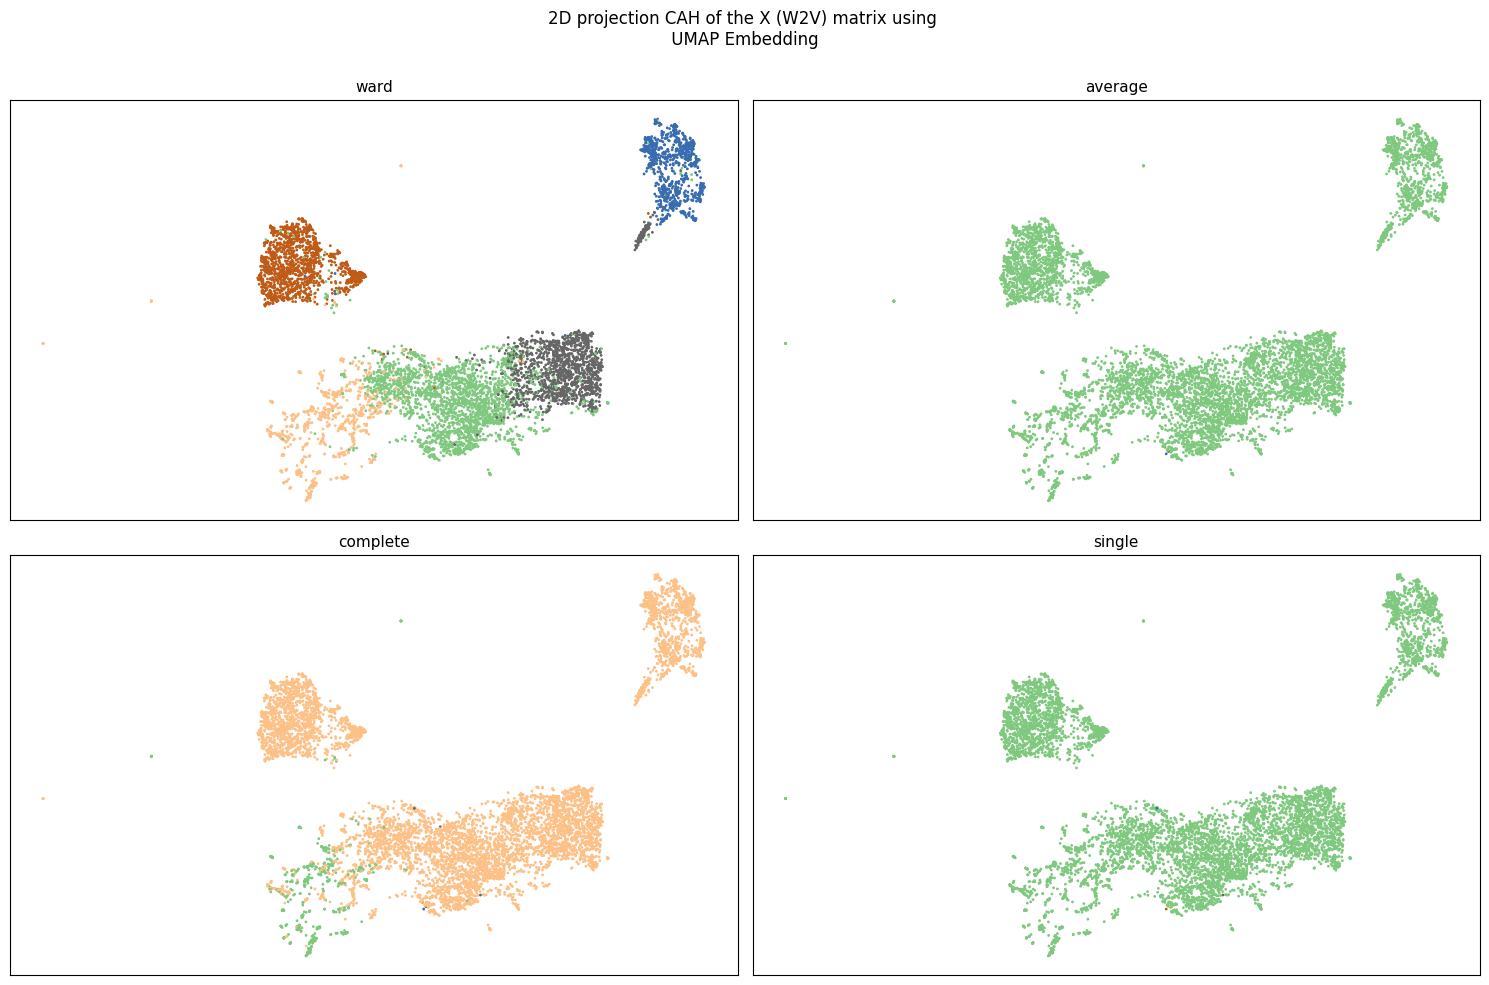

In [73]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("2D projection CAH of the X (W2V) matrix using \n UMAP Embedding \n", size=12)

umap_init = 'random' #  ou 'spectral'
for ax, lk in zip(axs.flat, linkage):

    # select reduction umap method for plotting
    X_red = w2v_umap_emb_irnd if umap_init == 'random' else w2v_umap_emb_ispt

    clustering = AgglomerativeClustering(linkage=lk, n_clusters=5)
    clustering.fit(X_w2v)

    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=clustering.labels_,
        cmap='Accent',
        s=1
    )
    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    ax.set_title(f'{lk}', size=11)
save_fig(f"{document_name}_CAH_CLUSTERING_VARIOUS_LINKAGE_2Dplot")
plt.show()

In [74]:
cah_ward_per_k = [AgglomerativeClustering(linkage="ward", n_clusters=k).fit(X_w2v) for k in range(1, 11)]

In [75]:
silhouette_scores_cah_ward = [metrics.silhouette_score(X_w2v, model.labels_) for model in cah_ward_per_k[1:]]

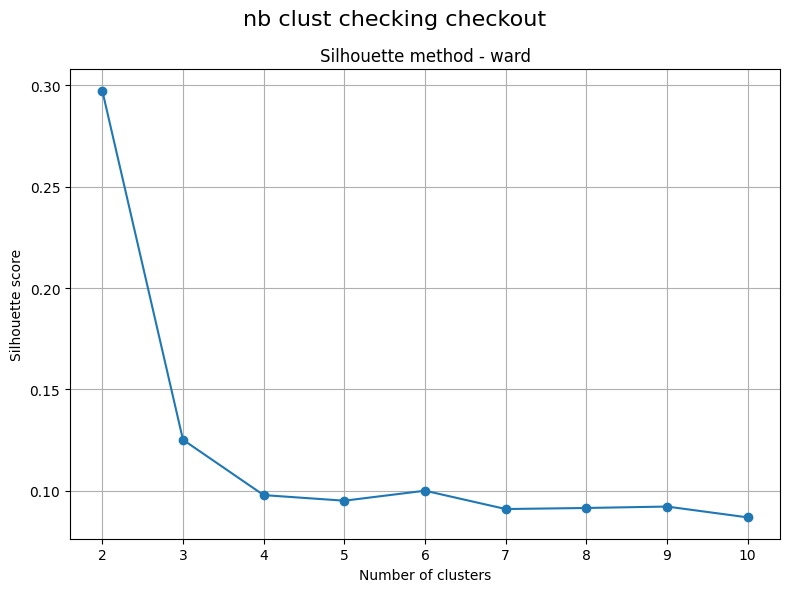

In [76]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle("nb clust checking checkout", size=16)

plot = ax.plot(range(2,11), silhouette_scores_cah_ward, marker='o')
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Silhouette score")
ax.set_title("Silhouette method - ward", size=12)
ax.grid()
plt.tight_layout()
save_fig(f"{document_name}_W2V_KMENOID_BEST_NB_CLUST_SILHOUETTE_SCORE_Line_plot")
plt.show()

In [77]:
cah_ward_per_linkage_k5 = [AgglomerativeClustering(linkage=lk, n_clusters=5).fit(X_w2v) for lk in linkage]

In [78]:
t0 = time()
cah_single = AgglomerativeClustering(linkage="single", n_clusters=5).fit(X_w2v)
t = time() - t0
evaluate(labels_= cah_single.labels_, X= X_w2v, name="cah-single", metric=None, dset=f"{document_name}-w2v", train_times=t)

Homogeneity: 0.642 ± 0.165
Completeness: 0.538 ± 0.116
V-measure: 0.583 ± 0.148
Rand index: 0.766 ± 0.117
ARI: 0.451 ± 0.121
MI: 0.825 ± 0.212
NMI: 0.583 ± 0.148
Silhouette Coefficient: 0.147 ± 0.125


In [79]:
t0 = time()
AgglomerativeClustering(linkage="average", n_clusters=5).fit(X_w2v)
t = time() - t0
evaluate(labels_= cah_single.labels_, X= X_w2v, name="cah-average", metric=None, dset=f"{document_name}-w2v", train_times=t)

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Number of Labels produced by the average cah is 1: impossible to evaluate it with evaluate function ( problem in computing silhouette score)

In [81]:
t0 = time()
AgglomerativeClustering(linkage="complete", n_clusters=5).fit(X_w2v)
t = time() - t0
evaluate(labels_= cah_single.labels_, X= X_w2v, name="cah-complete", metric=None, dset=f"{document_name}-w2v", train_times=t)

Homogeneity: 0.575 ± 0.251
Completeness: 0.490 ± 0.178
V-measure: 0.522 ± 0.227
Rand index: 0.718 ± 0.179
ARI: 0.403 ± 0.179
MI: 0.738 ± 0.323
NMI: 0.522 ± 0.227
Silhouette Coefficient: 0.176 ± 0.171


In [82]:
t0 = time()
AgglomerativeClustering(linkage="ward", n_clusters=5).fit(X_w2v)
t = time() - t0
evaluate(labels_= cah_single.labels_, X= X_w2v, name="cah-ward", metric=None, dset=f"{document_name}-w2v", train_times=t)

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Number of Labels produced by the ward cah is 1: impossible to evaluate it with evaluate function ( problem in computing silhouette score)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 10), sharey=True)

df_clust_ori = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_clust_ori_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df_clust_ori.drop(
    ["train_time", "dset", "metric"], # we don't need plotting those (non--numeric)
    axis="columns",
).plot.barh(ax=ax0, xerr=df_clust_ori_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df_clust_ori["train_time"].plot.barh(ax=ax1, xerr=df_clust_ori_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()
######

In [ ]:
# summary dataframe of clustering on original data
df_clust_ori.head(n=10)

In [ ]:
df_clust_ori.to_latex(
    index=["estimator"],
    columns=["ARI", "PMI", "NMI", "Silhouette Coefficient"],
    formatters={"name": str.upper},
    float_format="{:.2f}".format,
)

## <span style='color:#F9A861; font-weight: bold;'> DONNEES REDUITES </span>
---

In [88]:
IMAGES_PATH = Path.cwd().parent.parent / "images" / "unsupervised_learning" / f"{document_name}-red"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

In [89]:
from collections import defaultdict
from sklearn import metrics
from time import time
from time import sleep

evaluations_red = []
evaluations_red_std = []

scores_red = defaultdict(list)

labels = topic_colors

def evaluate_red(labels_, X, name=None, metric=None, dset=None, train_times=None):
    scores_red["Homogeneity"].append(metrics.homogeneity_score(labels, labels_))
    scores_red["Completeness"].append(metrics.completeness_score(labels, labels_))
    scores_red["V-measure"].append(metrics.v_measure_score(labels, labels_))
    scores_red["Rand index"].append(
        metrics.rand_score(labels, labels_)
    )
    scores_red["ARI"].append(
        metrics.adjusted_rand_score(labels, labels_)
    )
    scores_red["MI"].append(
        metrics.mutual_info_score(labels, labels_)
    )
    scores_red["NMI"].append(
        metrics.normalized_mutual_info_score(labels, labels_)
    )
    scores_red["Silhouette Coefficient"].append(
        metrics.silhouette_score(X, labels_, sample_size=2000)
    )

    evaluation_red = {
        "dset": dset,
        "estimator": name,
        "metric": metric,
        "train_time": train_times,
    }
    evaluation_red_std = {
        "dset": dset, # origin or reduced
        "estimator": name,
        "metric": metric,
        "train_time": train_times,
    }
    for score_name, score_values in scores_red.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation_red[score_name] = mean_score
        evaluation_red_std[score_name] = std_score
    evaluations_red.append(evaluation_red)
    evaluations_red_std.append(evaluation_red_std)

def fit_and_evaluate_red(km, X, name=None, metric=None, dset=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    for seed in range(n_runs):

        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores_red["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores_red["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores_red["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores_red["Rand index"].append(
            metrics.rand_score(labels, km.labels_)
        )
        scores_red["ARI"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores_red["MI"].append(
            metrics.mutual_info_score(labels, km.labels_)
        )
        scores_red["NMI"].append(
            metrics.normalized_mutual_info_score(labels, km.labels_)
        )
        scores_red["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)
    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")

    evaluation_red = {
        "dset": dset,
        "estimator": name,
        "metric": metric,
        "train_time": train_times.mean(),
    }
    evaluation_red_std = {
        "dset": dset, # origin or reduced
        "estimator": name,
        "metric": metric,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores_red.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation_red[score_name] = mean_score
        evaluation_red_std[score_name] = std_score
    evaluations_red.append(evaluation_red)
    evaluations_red_std.append(evaluation_red_std)

### >> <span style='color:#3390FF; font-weight: bold;'> UMAP</span>

#### >> >> >>  Kmeans

In [90]:
km_w2v_red = cluster.KMeans(
    n_clusters=5,
    n_init=10,
    max_iter=300,
    tol=1e-04,
    init='random',
    random_state=123
)

km_w2v_red_rnd_fit = km_w2v_red.fit(w2v_umap_emb_irnd)
km_w2v_red_spt_fit = km_w2v_red.fit(w2v_umap_emb_ispt)

km_lab_w2v_umap_emb_irnd = km_w2v_red.fit_predict(w2v_umap_emb_irnd)
km_lab_w2v_umap_emb_spt = km_w2v_red.fit_predict(w2v_umap_emb_ispt)

In [91]:
umap_methods = [
    ('o1', "UMAP metric=cosine, init=random", w2v_umap_emb_irnd, topic_colors),
    ('c1', "Check Clustering - UMAP metric=cosine, init=random", w2v_umap_emb_irnd, km_lab_w2v_umap_emb_irnd),
    ('o2', "UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, topic_colors),
    ('c2', "Check Clustering UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, km_lab_w2v_umap_emb_spt)
]

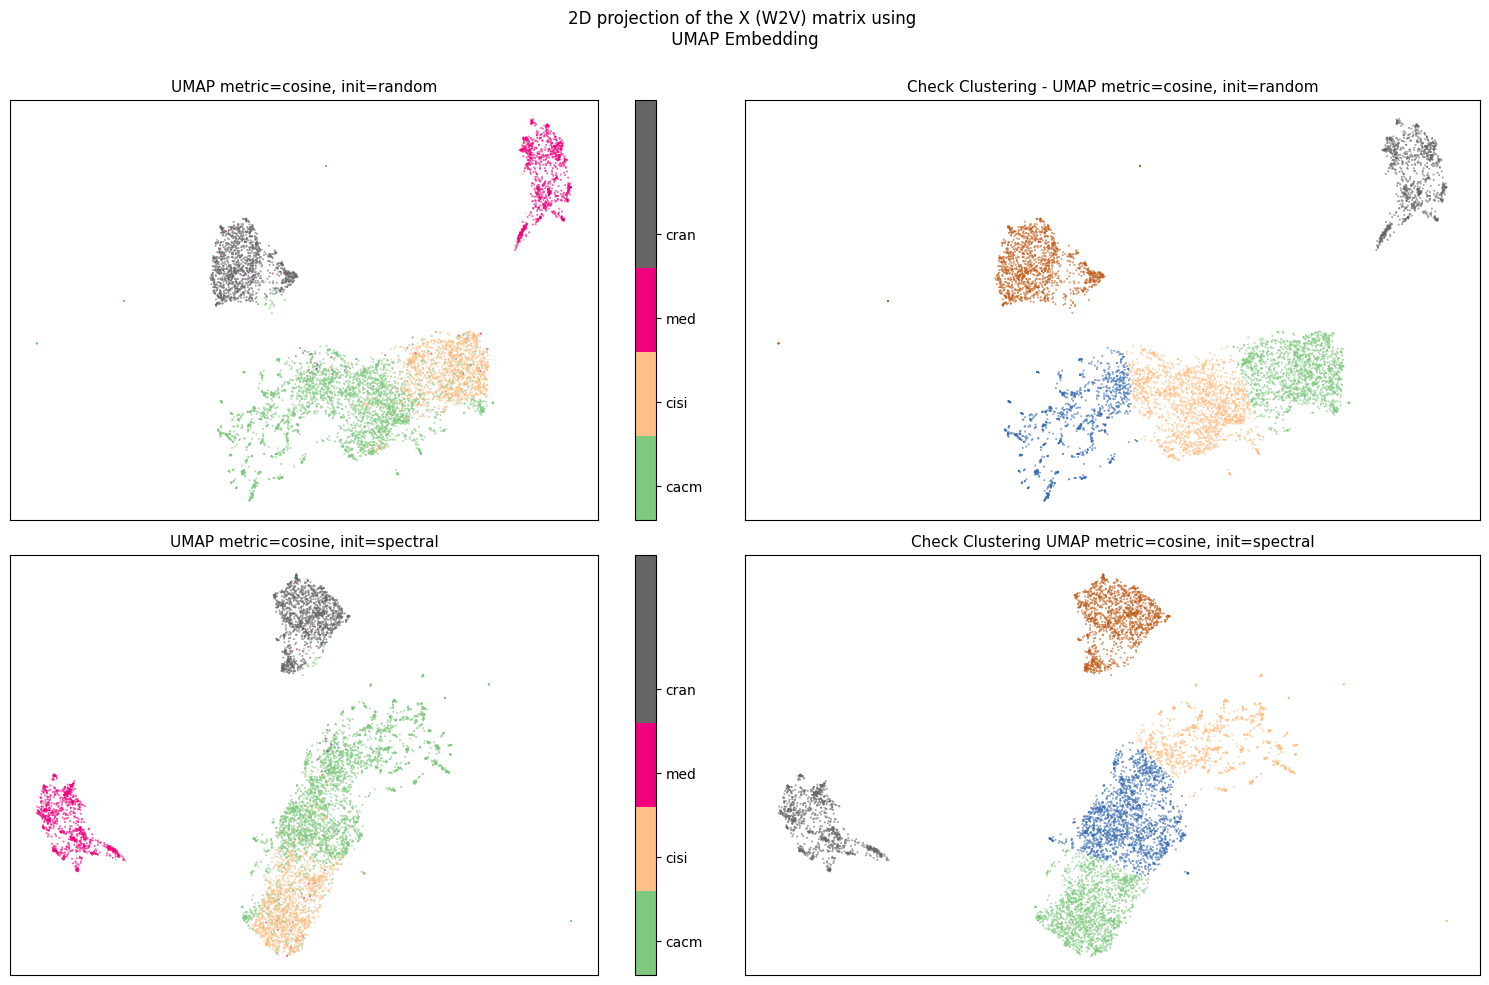

In [100]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("2D projection of the X (W2V) matrix using \n UMAP Embedding \n", size=12)

for ax, method in zip(axs.flat, umap_methods):
    tag, name, X_red, cmap = method
    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=cmap,
        cmap='Accent',
        s=0.1
    )

    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    if tag not in ['c1', 'c2']:
        cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
        cbar.set_ticks(np.arange(len(classes)))
        cbar.set_ticklabels(classes, size=10)
    ax.set_title(name, size=11)
save_fig("classic4_W2V_ORIGNINAL_VS_KMEANS_CULSTERING_UMAP_2Dplot")
plt.show()

In [101]:
# random reducted
fit_and_evaluate_red(
    km_w2v_red, # model or estimator
    w2v_umap_emb_irnd, # matrix original
    name="k-means _ rnd",
    dset="classic4-w2v-rnd-red"
)
print("========")
# spectral reduced
fit_and_evaluate_red(
    km_w2v_red,  # model or estimator
    w2v_umap_emb_ispt,  # matrix original
    name="k-means _ spt",
    dset="classic4-w2v-spt-red"
)

clustering done in 0.99 ± 1.80 s 
Homogeneity: 0.795 ± 0.000
Completeness: 0.645 ± 0.000
V-measure: 0.712 ± 0.000
Rand index: 0.842 ± 0.000
ARI: 0.592 ± 0.000
MI: 1.022 ± 0.000
NMI: 0.712 ± 0.000
Silhouette Coefficient: 0.578 ± 0.004
clustering done in 0.11 ± 0.03 s 
Homogeneity: 0.797 ± 0.002
Completeness: 0.647 ± 0.002
V-measure: 0.715 ± 0.002
Rand index: 0.842 ± 0.000
ARI: 0.592 ± 0.001
MI: 1.025 ± 0.003
NMI: 0.715 ± 0.002
Silhouette Coefficient: 0.580 ± 0.004


In [ ]:
# Pourcentage of variance or distortion
print(f'Distortion: {km_w2v_red_rnd_fit.inertia_:.2f}')
print(f'Distortion: {km_w2v_red_spt_fit.inertia_:.2f}')

###### $\rightarrow$  Elbow method to Estimate number of clusters needs


In [ ]:
kmeans_rnd_per_k = \
    [cluster.KMeans(
        n_clusters=k,
        init='random',
        n_init=10,
        tol=1e-04,
        max_iter=300,
        random_state=0
    ).fit(w2v_umap_emb_irnd)
     for k in range(1, 11)]

kmeans_spt_per_k = \
    [cluster.KMeans(
        n_clusters=k,
        init='random',
        n_init=10,
        tol=1e-04,
        max_iter=300,
        random_state=0
    ).fit(w2v_umap_emb_ispt)
     for k in range(1, 11)]

In [ ]:
inertias_rnd = [model.inertia_ for model in kmeans_rnd_per_k]
inertias_spt = [model.inertia_ for model in kmeans_spt_per_k]
silhouette_scores_rnd = [metrics.silhouette_score(w2v_umap_emb_irnd, model.labels_)
                         for model in kmeans_rnd_per_k[1:]]
silhouette_scores_spt = [metrics.silhouette_score(w2v_umap_emb_ispt, model.labels_)
                         for model in kmeans_spt_per_k[1:]]

In [ ]:
nbcluster_choice_methods = [
    ("Elbow method - rnd", range(1,11), inertias_rnd, "Number of clusters", "Distortion"),
    ("Silhouette method -spt", range(2,11), silhouette_scores_rnd, "Number of clusters", "Silhouette score"),
    ("Elbow method - rnd", range(1,11), inertias_spt, "Number of clusters", "Distortion"),
    ("Silhouette method -spt ", range(2,11), silhouette_scores_spt, "Number of clusters", "Silhouette score")
]

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("nb clust checking checkout", size=16)

for ax, nbclust in zip(axs.flat, nbcluster_choice_methods):
    name, x, inertias, xlab, ylab = nbclust
    plot = ax.plot(x, inertias, marker='o')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(name, size=12)
    ax.grid()
plt.tight_layout()
save_fig("bbc_W2V_KMENOID_BEST_NB_CLUST_SILHOUETTE_SCORE_Line_plot")
plt.show()

In [ ]:
### None

#### >> >> >>  Kmeans++

In [102]:
kmpp_w2v_red = cluster.KMeans(
    n_clusters=5,
    n_init=10,
    max_iter=300,
    tol=1e-04,
    init='k-means++',
    random_state=123
)

kmpp_w2v_red_rnd_fit = kmpp_w2v_red.fit(w2v_umap_emb_irnd)
kmpp_w2v_red_spt_fit = kmpp_w2v_red.fit(w2v_umap_emb_ispt)

kmpp_lab_w2v_umap_emb_irnd = kmpp_w2v_red.fit_predict(w2v_umap_emb_irnd)
kmpp_lab_w2v_umap_emb_spt = kmpp_w2v_red.fit_predict(w2v_umap_emb_ispt)

In [103]:
umap_methods = [
    ('o1', "UMAP metric=cosine, init=random", w2v_umap_emb_irnd, topic_colors),
    ('c1', "Check Clustering - UMAP metric=cosine, init=random", w2v_umap_emb_irnd, kmpp_lab_w2v_umap_emb_irnd),
    ('o2', "UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, topic_colors),
    ('c2', "Check Clustering UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, kmpp_lab_w2v_umap_emb_spt)
]

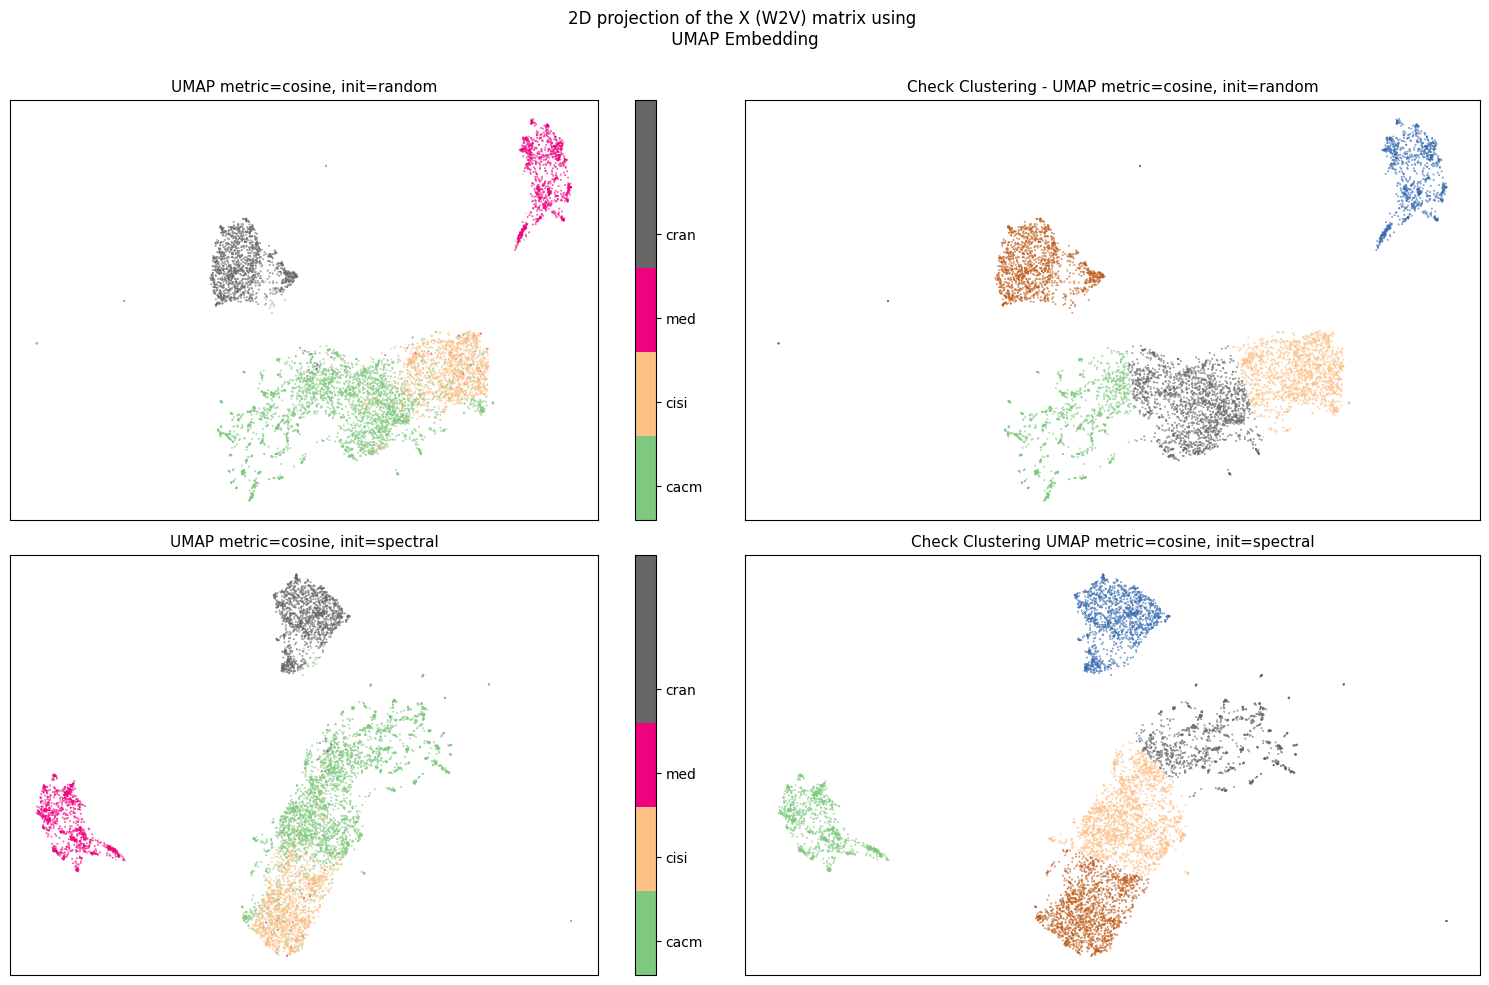

In [104]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("2D projection of the X (W2V) matrix using \n UMAP Embedding \n", size=12)

for ax, method in zip(axs.flat, umap_methods):
    tag, name, X_red, cmap = method
    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=cmap,
        cmap='Accent',
        s=0.1
    )

    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    if tag not in ['c1', 'c2']:
        cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
        cbar.set_ticks(np.arange(len(classes)))
        cbar.set_ticklabels(classes, size=10)
    ax.set_title(name, size=11)
save_fig("classic4_W2V_ORIGNINAL_VS_KMEANS_CULSTERING_UMAP_2Dplot")
plt.show()

In [105]:
# random reducted
fit_and_evaluate_red(
    kmpp_w2v_red, # model or estimator
    w2v_umap_emb_irnd, # matrix original
    name="k-means++ - rnd",
    dset="classic4-w2v-rnd-red"
)
print("========")
# spectral reduced
fit_and_evaluate_red(
    kmpp_w2v_red,  # model or estimator
    w2v_umap_emb_ispt,  # matrix original
    name="k-means++ - spt",
    dset="classic4-w2v-spt-red"
)

clustering done in 1.13 ± 1.89 s 
Homogeneity: 0.797 ± 0.002
Completeness: 0.647 ± 0.002
V-measure: 0.714 ± 0.002
Rand index: 0.842 ± 0.000
ARI: 0.592 ± 0.001
MI: 1.024 ± 0.003
NMI: 0.714 ± 0.002
Silhouette Coefficient: 0.580 ± 0.004
clustering done in 0.14 ± 0.05 s 
Homogeneity: 0.797 ± 0.002
Completeness: 0.647 ± 0.002
V-measure: 0.715 ± 0.002
Rand index: 0.842 ± 0.000
ARI: 0.592 ± 0.000
MI: 1.025 ± 0.003
NMI: 0.715 ± 0.002
Silhouette Coefficient: 0.582 ± 0.005


In [ ]:
# Pourcentage of variance or distortion
print(f'Distortion: {km_w2v_red_rnd_fit.inertia_:.2f}')
print(f'Distortion: {km_w2v_red_spt_fit.inertia_:.2f}')

###### $\rightarrow$  Elbow method to Estimate number of clusters needs


In [ ]:
kmeanspp_rnd_per_k = \
    [cluster.KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=10,
        tol=1e-04,
        max_iter=300,
        random_state=0
    ).fit(w2v_umap_emb_irnd)
     for k in range(1, 11)]

kmeanspp_spt_per_k = \
    [cluster.KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=10,
        tol=1e-04,
        max_iter=300,
        random_state=0
    ).fit(w2v_umap_emb_ispt)
     for k in range(1, 11)]

In [ ]:
inertias_rnd = [model.inertia_ for model in kmeanspp_rnd_per_k]
inertias_spt = [model.inertia_ for model in kmeanspp_spt_per_k]
silhouette_scores_rnd = [metrics.silhouette_score(w2v_umap_emb_irnd, model.labels_)
                         for model in kmeanspp_rnd_per_k[1:]]
silhouette_scores_spt = [metrics.silhouette_score(w2v_umap_emb_ispt, model.labels_)
                         for model in kmeanspp_spt_per_k[1:]]

In [ ]:
nbcluster_choice_methods = [
    ("Elbow method - rnd", range(1,11), inertias_rnd, "Number of clusters", "Distortion"),
    ("Silhouette method -spt", range(2,11), silhouette_scores_rnd, "Number of clusters", "Silhouette score"),
    ("Elbow method - rnd", range(1,11), inertias_spt, "Number of clusters", "Distortion"),
    ("Silhouette method -spt ", range(2,11), silhouette_scores_spt, "Number of clusters", "Silhouette score")
]

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("nb clust checking checkout", size=16)

for ax, nbclust in zip(axs.flat, nbcluster_choice_methods):
    name, x, inertias, xlab, ylab = nbclust
    plot = ax.plot(x, inertias, marker='o')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(name, size=12)
    ax.grid()
plt.tight_layout()
save_fig("classic4_W2V_KMENOID_BEST_NB_CLUST_SILHOUETTE_SCORE_Line_plot")
plt.show()

#### >> >> >>  Kmedoids

In [106]:
kmd_w2v_red_cos = KMedoids(
    metric="cosine",
    n_clusters=5,
    random_state=123,
    max_iter=300
)

kmd_w2v_red_mnt = KMedoids(
    metric="manhattan",
    n_clusters=5,
    random_state=123,
    max_iter=300
)

clr_w2v_red_cos = CLARA(
    metric="cosine",
    n_clusters=5,
    init="heuristic",
    n_sampling=250,
    random_state=123
)

clr_w2v_red_mnt = CLARA(
    metric="manhattan",
    n_clusters=5,
    init="heuristic",
    n_sampling=250,
    random_state=123
)

clustering_algorithms_metrics = [
    ('kcos', "K-Medoid metric=cosine \n UMAP metric=cosine, init=random", kmd_w2v_red_cos),
    ('kmnt', "K-Medoid metric=manathan \n UMAP metric=cosine, init=random", kmd_w2v_red_mnt),
    ('rcos', "CLARA metric=cosine \n UMAP metric=cosine, init=random", clr_w2v_red_cos),
    ('rmnt', "CLARA metric=manathan \nUMAP metric=cosine, init=spectral", clr_w2v_red_mnt),
]


In [107]:
umap_mth = [
    ('o1', "UMAP metric=cosine", w2v_umap_emb_irnd, topic_colors),
    ('kc', "KMenoids metric=cosine", w2v_umap_emb_irnd, kmpp_lab_w2v),
    ('km', "KMenoids metric=manhattan", w2v_umap_emb_irnd, kmpp_lab_w2v),
]

umap_mth_spt = [
    ('o2', "UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, topic_colors),
    ('o2', "UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, topic_colors),
    ('o2', "UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, topic_colors),
]

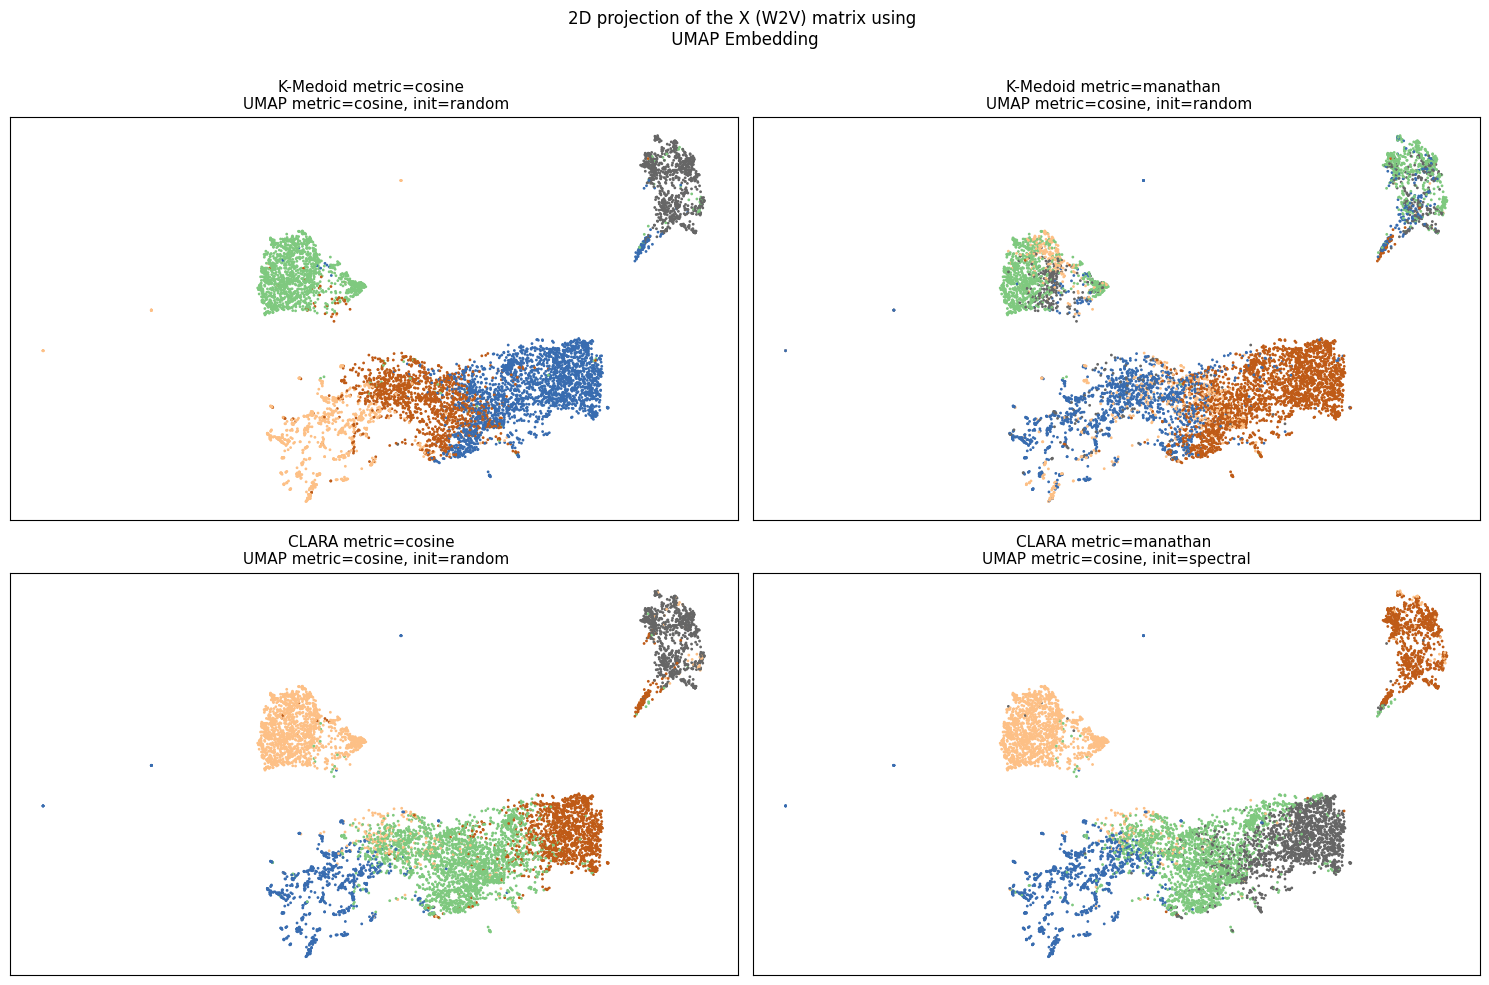

In [108]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("2D projection of the X (W2V) matrix using \n UMAP Embedding \n", size=12)

umap_init = 'random' #  ou 'spectral'
for ax, algorithm in zip(axs.flat, clustering_algorithms_metrics):
    tag, name, model = algorithm

    # on entraine les modèles
    model.fit(X_w2v)

    # dépendamment de l'implémentation, on peut avoir des attributs labels_ ou non
    if hasattr(model, "labels_"):
        y_pred = model.labels_.astype(int)
    else:
        y_pred = model.predict(w2v_umap_emb_irnd)

    # select reduction umap method for plotting
    X_red = w2v_umap_emb_irnd if umap_init == 'random' else w2v_umap_emb_ispt

    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=y_pred,
        cmap='Accent',
        s=1
    )
    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    ax.set_title(name, size=11)
save_fig("classic4_KMENOID_VS_CLARA_RANDOM_INIT_CLUSTERING_2Dplot")
plt.show()

In [109]:
fit_and_evaluate_red(
    kmd_w2v_red_cos, # model
    w2v_umap_emb_irnd, # matrix original
    name="kmenoid-cos",
    metric="cosine",
    dset="classic4-w2v-rnd-red"
)

/home/khaldi/.cache/pypoetry/virtualenvs/text-clust-h_mCOXh5-py3.10/lib/python3.10/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
/home/khaldi/.cache/pypoetry/virtualenvs/text-clust-h_mCOXh5-py3.10/lib/python3.10/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
/home/khaldi/.cache/pypoetry/virtualenvs/text-clust-h_mCOXh5-py3.10/lib/python3.10/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
/home/khaldi/.cache/pypoetry/virtualenvs/text-clust-h_mCOXh5-py3.10/lib/python3.10/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluste

clustering done in 1.68 ± 0.16 s 
Homogeneity: 0.722 ± 0.151
Completeness: 0.588 ± 0.118
V-measure: 0.648 ± 0.132
Rand index: 0.813 ± 0.058
ARI: 0.521 ± 0.143
MI: 0.928 ± 0.194
NMI: 0.648 ± 0.132
Silhouette Coefficient: 0.502 ± 0.160


In [110]:
fit_and_evaluate_red(
    kmd_w2v_red_mnt, # model
    w2v_umap_emb_irnd, # matrix original
    name="kmenoid-mnt",
    metric="manhattan",
    dset="classic4-w2v-rnd-red"
)

clustering done in 1.06 ± 0.33 s 
Homogeneity: 0.734 ± 0.140
Completeness: 0.597 ± 0.109
V-measure: 0.659 ± 0.123
Rand index: 0.818 ± 0.054
ARI: 0.532 ± 0.133
MI: 0.943 ± 0.180
NMI: 0.659 ± 0.123
Silhouette Coefficient: 0.515 ± 0.149


In [ ]:
# Pourcentage of variance or distortion
print(f'Distortion: {kmd_w2v_red_cos.inertia_:.2f}')
# Pourcentage of variance or distortion
print(f'Distortion: {kmd_w2v_red_mnt.inertia_:.2f}')

In [ ]:
kmd_rnd_red_cos_per_k = \
    [KMedoids(
        metric="cosine",
        n_clusters=k,
        random_state=123,
        max_iter=300
    ).fit(w2v_umap_emb_irnd)
     for k in range(1, 11)]

In [ ]:
kmd_rnd_red_mnt_per_k = \
    [KMedoids(
        metric="manhattan",
        n_clusters=k,
        random_state=123,
        max_iter=300
    ).fit(w2v_umap_emb_irnd)
     for k in range(1, 11)]

In [ ]:
inertias_kmd_cos = [model.inertia_ for model in kmd_rnd_red_cos_per_k]
inertias_kmd_mnt = [model.inertia_ for model in kmd_rnd_red_mnt_per_k]
silhouette_scores_cos = [metrics.silhouette_score(w2v_umap_emb_irnd, model.labels_)
                         for model in kmenoid_cos_per_k[1:]]
silhouette_scores_mnt = [metrics.silhouette_score(w2v_umap_emb_irnd, model.labels_)
                         for model in kmenoid_mnt_per_k[1:]]

###### $\rightarrow$ Elbow method to Estimate number of clusters needs

In [ ]:
nbcluster_choice_methods = [
    ("Elbow method - cos", range(1,11), inertias_kmd_cos, "Number of clusters", "Distortion"),
    ("Silhouette method - cos", range(2,11), silhouette_scores_cos, "Number of clusters", "Silhouette score"),
    ("Elbow method - mnt", range(1,11), inertias_kmd_mnt, "Number of clusters", "Distortion"),
    ("Silhouette method - mnt ", range(2,11), silhouette_scores_mnt, "Number of clusters", "Silhouette score")
]

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("nb clust checking checkout", size=16)

for ax, nbclust in zip(axs.flat, nbcluster_choice_methods):
    name, x, inertias, xlab, ylab = nbclust
    plot = ax.plot(x, inertias, marker='o')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(name, size=12)
    ax.grid()
plt.tight_layout()
save_fig("bbc_W2V_KMENOID_BEST_NB_CLUST_SILHOUETTE_SCORE_Line_plot")
plt.show()

#### >> >> >>  Sphérical Kmean

In [111]:
skm = SphericalKmeans(
    n_clusters=5,
    n_init=10,
    tol=1e-4,
    max_iter=300
)

In [112]:
t0 = time()
skm.fit(w2v_umap_emb_irnd)
t = time() - t0

 == New init == 
iteration: 0
6631.809012317399
iteration: 1
7032.803437903624
iteration: 2
7063.645635685023
iteration: 3
7070.688606915839
iteration: 4
7073.489387985928
iteration: 5
7075.613016609994
iteration: 6
7076.864378883163
iteration: 7
7077.229605743129
iteration: 8
7077.311245879206
iteration: 9
7077.331205745819
iteration: 10
7077.335080384919
iteration: 11
7077.335768144714
iteration: 12
7077.336031302018
iteration: 13
7077.336096766105
iteration: 14
7077.336209019832
iteration: 15
7077.336214738218
iteration: 16
 == New init == 
iteration: 0
6620.925956483367
iteration: 1
7031.603644955613
iteration: 2
7063.189688944967
iteration: 3
7070.608016171671
iteration: 4
7073.385370872745
iteration: 5
7075.514075061639
iteration: 6
7076.829991253428
iteration: 7
7077.21740962462
iteration: 8
7077.303153244439
iteration: 9
7077.330168196464
iteration: 10
7077.334788257714
iteration: 11
7077.335541676704
iteration: 12
7077.335928690205
iteration: 13
7077.335973594714
iteration: 14

In [113]:
skm_labels = skm.labels_

In [114]:
evaluate_red(
    labels_= skm_labels, # label
    X= w2v_umap_emb_irnd, # matrix original
    name="skm _ rnd",
    metric=None,
    dset="bbc-rnd-red-w2v",
    train_times=t
)

Homogeneity: 0.724 ± 0.148
Completeness: 0.590 ± 0.116
V-measure: 0.650 ± 0.130
Rand index: 0.814 ± 0.057
ARI: 0.523 ± 0.141
MI: 0.930 ± 0.191
NMI: 0.650 ± 0.130
Silhouette Coefficient: 0.505 ± 0.157


In [ ]:
space = [
    ('org', "Origin", topic_colors),
    ('skm', "skm (color just means cluster discovered)", skm_labels)
]

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
fig.suptitle("2D projection of the X (W2V) matrix using \n UMAP Embedding \n", size=12)

umap_init = 'random' #  ou 'spectral'
for ax, sp in zip(axs.flat, space):
    tag, name, cmap = sp

    # select reduction umap method
    X_red = w2v_umap_emb_irnd if umap_init == 'random' else w2v_umap_emb_ispt

    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=cmap,
        cmap='Accent',
        s=1
    )
    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    ax.set_title(name, size=11)
save_fig("bbc_KMENOID_VS_CLARA_RANDOM_INIT_CLUSTERING_2Dplot")
plt.show()

#### >> >> >>  CAH

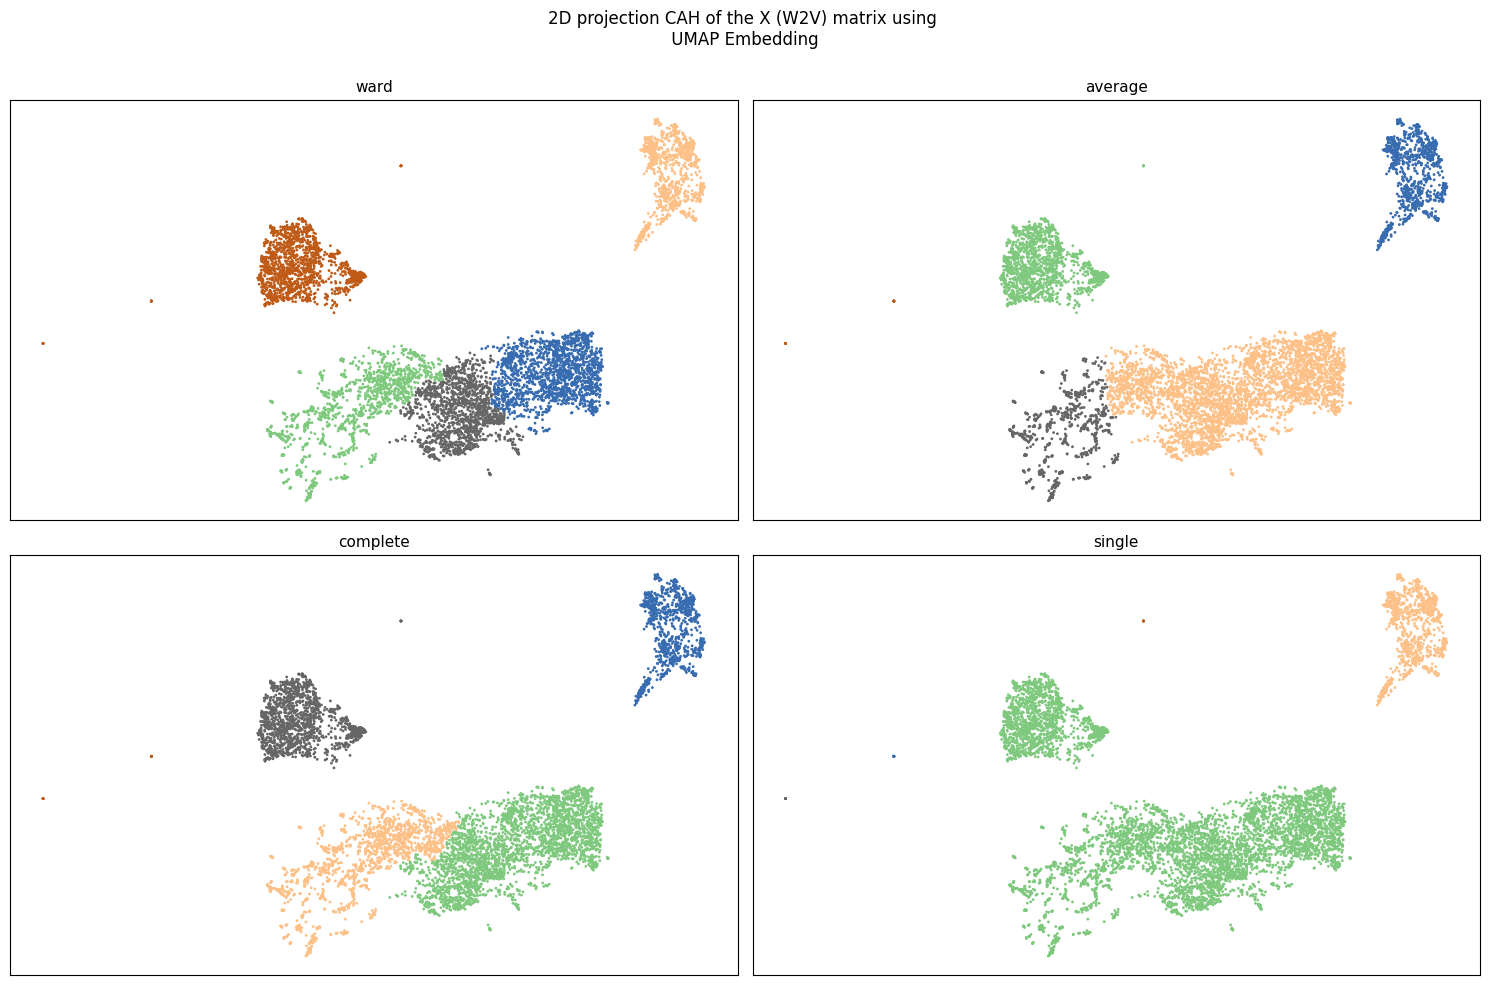

In [115]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("2D projection CAH of the X (W2V) matrix using \n UMAP Embedding \n", size=12)

umap_init = 'random' #  ou 'spectral'
for ax, lk in zip(axs.flat, linkage):

    # select reduction umap method for plotting
    X_red = w2v_umap_emb_irnd if umap_init == 'random' else w2v_umap_emb_ispt

    clustering = AgglomerativeClustering(linkage=lk, n_clusters=5)
    clustering.fit(w2v_umap_emb_irnd)

    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=clustering.labels_,
        cmap='Accent',
        s=1
    )
    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    ax.set_title(f'{lk}', size=11)
save_fig("bbc_CAH_CLUSTERING_VARIOUS_LINKAGE_2Dplot")
plt.show()

In [116]:
cah_ward_per_k = [AgglomerativeClustering(linkage="ward", n_clusters=k).fit(w2v_umap_emb_irnd) for k in range(1, 11)]

In [117]:
silhouette_scores_cah_ward = [metrics.silhouette_score(w2v_umap_emb_irnd, model.labels_) for model in cah_ward_per_k[1:]]

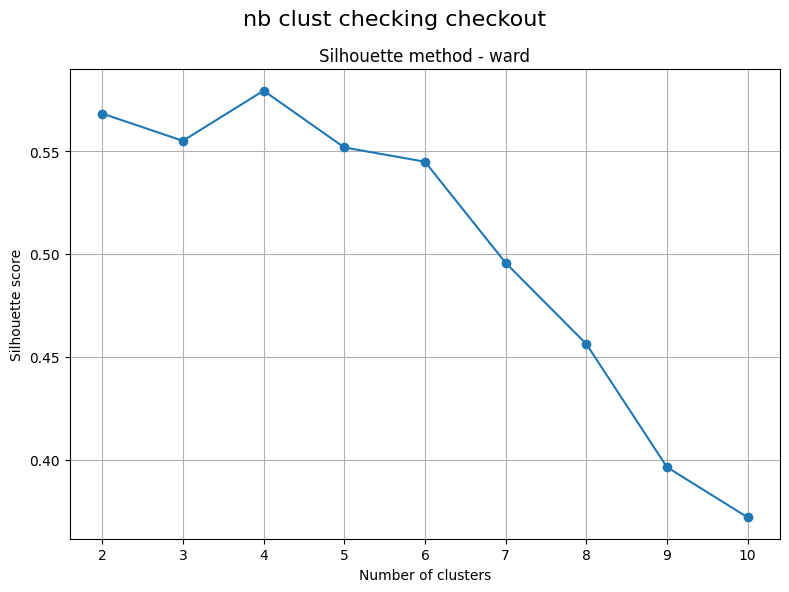

In [118]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle("nb clust checking checkout", size=16)

plot = ax.plot(range(2,11), silhouette_scores_cah_ward, marker='o')
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Silhouette score")
ax.set_title("Silhouette method - ward", size=12)
ax.grid()
plt.tight_layout()
save_fig("classic4_W2V_KMENOID_BEST_NB_CLUST_SILHOUETTE_SCORE_Line_plot")
plt.show()

In [119]:
cah_ward_per_linkage_k5 = [AgglomerativeClustering(linkage=lk, n_clusters=5).fit(w2v_umap_emb_irnd) for lk in linkage]

In [120]:
t0 = time()
cah_single = AgglomerativeClustering(linkage="single", n_clusters=5).fit(w2v_umap_emb_irnd)
t = time() - t0
evaluate_red(labels_= cah_single.labels_, X= w2v_umap_emb_irnd, name="cah-single", metric=None, dset="bbc-rnd-red-w2v", train_times=t)

Homogeneity: 0.711 ± 0.163
Completeness: 0.599 ± 0.127
V-measure: 0.644 ± 0.133
Rand index: 0.806 ± 0.072
ARI: 0.514 ± 0.147
MI: 0.913 ± 0.210
NMI: 0.644 ± 0.133
Silhouette Coefficient: 0.499 ± 0.158


In [121]:
t0 = time()
AgglomerativeClustering(linkage="average", n_clusters=5).fit(w2v_umap_emb_irnd)
t = time() - t0
evaluate_red(labels_= cah_single.labels_, X= w2v_umap_emb_irnd, name="cah-average", metric=None, dset="bbc-rnd-red-w2v", train_times=t)

Homogeneity: 0.698 ± 0.175
Completeness: 0.609 ± 0.135
V-measure: 0.638 ± 0.134
Rand index: 0.798 ± 0.084
ARI: 0.506 ± 0.152
MI: 0.897 ± 0.225
NMI: 0.638 ± 0.134
Silhouette Coefficient: 0.494 ± 0.158


In [122]:
t0 = time()
AgglomerativeClustering(linkage="complete", n_clusters=5).fit(w2v_umap_emb_irnd)
t = time() - t0
evaluate_red(labels_= cah_single.labels_, X= w2v_umap_emb_irnd, name="cah-complete", metric=None, dset="classic4-rnd-red-w2v", train_times=t)

Homogeneity: 0.687 ± 0.185
Completeness: 0.617 ± 0.143
V-measure: 0.633 ± 0.136
Rand index: 0.791 ± 0.092
ARI: 0.498 ± 0.156
MI: 0.882 ± 0.237
NMI: 0.633 ± 0.136
Silhouette Coefficient: 0.489 ± 0.158


In [124]:
t0 = time()
AgglomerativeClustering(linkage="ward", n_clusters=5).fit(w2v_umap_emb_irnd)
t = time() - t0
evaluate_red(labels_= cah_single.labels_, X= w2v_umap_emb_irnd, name="cah-ward", metric=None, dset="classic4-rnd-red-w2v", train_times=t)

Homogeneity: 0.666 ± 0.200
Completeness: 0.633 ± 0.153
V-measure: 0.623 ± 0.138
Rand index: 0.777 ± 0.105
ARI: 0.484 ± 0.162
MI: 0.855 ± 0.256
NMI: 0.623 ± 0.138
Silhouette Coefficient: 0.480 ± 0.158


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 10), sharey=True)

df = pd.DataFrame(evaluations_red[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_red_std[::-1]).set_index("estimator")

df.drop(
    ["train_time", "dset", "metric"], # we don't need plotting those (non--numeric)
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()

In [ ]:
df.head()

### >> <span style='color:#3390FF; font-weight: bold;'> PCA </span>

In [ ]:
# réinitialisation
evaluations_red = []
evaluations_red_std = []
scores_red = defaultdict(list)

In [ ]:
IMAGES_PATH = Path.cwd().parent.parent / "images" / "unsupervised_learning" / "bbc-red-pca"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

#### >> >> >>  Kmeans

In [ ]:
km_w2v_pca_red = cluster.KMeans(
    n_clusters=5,
    n_init=10,
    max_iter=300,
    tol=1e-04,
    init='random',
    random_state=123
)

km_w2v_pca_red_fit = km_w2v_pca_red.fit(X_w2v_pca)
km_lab_w2v_pca_red = km_w2v_red.fit_predict(X_w2v_pca)

In [ ]:
pca_methods = [
    ('o1', "PCA metric=cosine, init=random", X_w2v_pca, topic_colors),
    ('c1', "Check Clustering - PCA, init=random", X_w2v_pca, km_lab_w2v_pca_red)
]

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle("2D projection of the X (W2V) matrix using \n", size=12)

for ax, method in zip(axs.flat, pca_methods):
    tag, name, X_red, cmap = method
    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=cmap,
        cmap='Accent',
        s=0.1
    )

    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    if tag not in ['c1', 'c2']:
        cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
        cbar.set_ticks(np.arange(5))
        cbar.set_ticklabels(classes, size=10)
    ax.set_title(name, size=11)
save_fig("bbc_W2V_ORIGNINAL_VS_KMEANS_CULSTERING_PCA_2Dplot")
plt.show()

In [ ]:
# random reducted
fit_and_evaluate_red(
    km_w2v_pca_red, # model or estimator
    X_w2v_pca, # matrix original
    name="k-means _ pca",
    dset="bbc-w2v-pca-red"
)

In [ ]:
print(f'Distortion: {km_w2v_pca_red_fit.inertia_:.2f}')

In [ ]:
kmeans_pca_per_k = \
    [cluster.KMeans(
        n_clusters=k,
        init='random',
        n_init=10,
        tol=1e-04,
        max_iter=300,
        random_state=0
    ).fit(X_w2v_pca)
     for k in range(1, 11)]

In [ ]:
inertias_pca = [model.inertia_ for model in kmeans_pca_per_k]

In [ ]:
silhouette_scores_pca = [metrics.silhouette_score(X_w2v_pca, model.labels_)
                         for model in kmeans_pca_per_k[1:]]

In [ ]:
nbcluster_choice_methods = [
    ("Elbow method - pca", range(1,11), inertias_pca, "Number of clusters", "Distortion"),
    ("Silhouette method - pca", range(2,11), silhouette_scores_pca, "Number of clusters", "Silhouette score"),
]

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
fig.suptitle("nb clust checking checkout", size=16)

for ax, nbclust in zip(axs.flat, nbcluster_choice_methods):
    name, x, inertias, xlab, ylab = nbclust
    plot = ax.plot(x, inertias, marker='o')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(name, size=12)
    ax.grid()
plt.tight_layout()
save_fig("bbc_W2V_KMENOID_BEST_NB_CLUST_SILHOUETTE_SCORE_Line_plot")
plt.show()

#### >> >> >>  Kmeans ++

In [ ]:
kmpp_w2v_pca_red = cluster.KMeans(
    n_clusters=5,
    n_init=10,
    max_iter=300,
    tol=1e-04,
    init='k-means++',
    random_state=123
)

kmpp_w2v_pca_red_fit = kmpp_w2v_red.fit(X_w2v_pca)
kmpp_lab_w2v_pca_red = kmpp_w2v_red.fit_predict(X_w2v_pca)

In [ ]:
umap_methods = [
    ('o1', "PCA, init=random", X_w2v_pca, topic_colors),
    ('c1', "Check Clustering - PCA, init=random", X_w2v_pca, kmpp_lab_w2v_pca_red),
]

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
fig.suptitle("2D projection of the X (W2V) matrix using \n PCA Embedding \n", size=12)

for ax, method in zip(axs.flat, umap_methods):
    tag, name, X_red, cmap = method
    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=cmap,
        cmap='Accent',
        s=0.1
    )

    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    if tag not in ['c1', 'c2']:
        cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
        cbar.set_ticks(np.arange(5))
        cbar.set_ticklabels(classes, size=10)
    ax.set_title(name, size=11)
save_fig("bbc_W2V_ORIGNINAL_VS_KMEANS_CULSTERING_PCA_2Dplot")
plt.show()

In [ ]:
fit_and_evaluate_red(
    kmpp_w2v_pca_red, # model or estimator
    X_w2v_pca, # matrix original
    name="k-means++ - pca",
    dset="bbc-w2v-pca-red"
)

In [ ]:
# Pourcentage of variance or distortion
print(f'Distortion: {km_w2v_pca_red_fit.inertia_:.2f}')

In [ ]:
kmeanspp_pca_per_k = \
    [cluster.KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=10,
        tol=1e-04,
        max_iter=300,
        random_state=0
    ).fit(X_w2v_pca)
     for k in range(1, 11)]

In [ ]:
inertias_pca = [model.inertia_ for model in kmeanspp_pca_per_k]
silhouette_scores_pca = [metrics.silhouette_score(X_w2v_pca, model.labels_) for model in kmeanspp_pca_per_k[1:]]

In [ ]:
nbcluster_choice_methods = [
    ("Elbow method - rnd", range(1,11), inertias_pca, "Number of clusters", "Distortion"),
    ("Silhouette method -spt", range(2,11), silhouette_scores_pca, "Number of clusters", "Silhouette score")
]

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 6))
fig.suptitle("nb clust checking checkout", size=16)

for ax, nbclust in zip(axs.flat, nbcluster_choice_methods):
    name, x, inertias, xlab, ylab = nbclust
    plot = ax.plot(x, inertias, marker='o')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(name, size=12)
    ax.grid()
plt.tight_layout()
save_fig("bbc_W2V_KMENOID_BEST_NB_CLUST_SILHOUETTE_SCORE_Line_plot")
plt.show()

#### >> >> >>  Kmedoids

In [ ]:
kmd_w2v_red_cos = KMedoids(
    metric="cosine",
    n_clusters=5,
    random_state=123,
    max_iter=300
)

kmd_w2v_red_mnt = KMedoids(
    metric="manhattan",
    n_clusters=5,
    random_state=123,
    max_iter=300
)

clr_w2v_red_cos = CLARA(
    metric="cosine",
    n_clusters=5,
    init="heuristic",
    n_sampling=250,
    random_state=123
)

clr_w2v_red_mnt = CLARA(
    metric="manhattan",
    n_clusters=5,
    init="heuristic",
    n_sampling=250,
    random_state=123
)

clustering_algorithms_metrics = [
    ('kcos', "K-Medoid metric=cosine \n PCA, init=random", kmd_w2v_red_cos),
    ('kmnt', "K-Medoid metric=manathan \n PCA, init=random", kmd_w2v_red_mnt),
    ('rcos', "CLARA metric=cosine \n PCA, init=random", clr_w2v_red_cos),
    ('rmnt', "CLARA metric=manathan \nPCA, init=spectral", clr_w2v_red_mnt),
]

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("2D projection of the X (W2V) matrix using\n PCA\n", size=12)

umap_init = 'random' #  ou 'spectral'
for ax, algorithm in zip(axs.flat, clustering_algorithms_metrics):
    tag, name, model = algorithm

    # on entraine les modèles
    model.fit(X_w2v_pca)

    # dépendamment de l'implémentation, on peut avoir des attributs labels_ ou non
    if hasattr(model, "labels_"):
        y_pred = model.labels_.astype(int)
    else:
        y_pred = model.predict(X_w2v_pca)

    # select reduction umap method for plotting
    X_red = X_w2v_pca

    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=y_pred,
        cmap='Accent',
        s=1
    )
    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    ax.set_title(name, size=11)
save_fig("bbc_KMENOID_VS_CLARA_RANDOM_INIT_CLUSTERING_2Dplot")
plt.show()

In [ ]:
fit_and_evaluate_red(
    kmd_w2v_red_cos, # model
    X_w2v_pca, # matrix original
    name="kmenoid-cos",
    metric="cosine",
    dset="bbc-w2v-pca-red"
)

In [ ]:
# Pourcentage of variance or distortion
print(f'Distortion: {kmd_w2v_red_cos.inertia_:.2f}')

In [ ]:
kmd_pca_red_cos_per_k = \
    [KMedoids(
        metric="cosine",
        n_clusters=k,
        random_state=123,
        max_iter=300
    ).fit(X_w2v_pca)
     for k in range(1, 11)]

In [ ]:
inertias_kmd_cos = [model.inertia_ for model in kmd_pca_red_cos_per_k]

In [ ]:
silhouette_scores_cos = [metrics.silhouette_score(X_w2v_pca, model.labels_)
                         for model in kmd_pca_red_cos_per_k[1:]]

###### $\rightarrow$ Silhouette method to Estimate number of clusters needs


In [ ]:
nbcluster_choice_methods = [
    ("Elbow method - cos", range(1,11), inertias_kmd_cos, "Number of clusters", "Distortion"),
    ("Silhouette method - cos", range(2,11), silhouette_scores_cos, "Number of clusters", "Silhouette score"),
]

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 6))
fig.suptitle("nb clust checking checkout", size=16)

for ax, nbclust in zip(axs.flat, nbcluster_choice_methods):
    name, x, inertias, xlab, ylab = nbclust
    plot = ax.plot(x, inertias, marker='o')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(name, size=12)
    ax.grid()
plt.tight_layout()
save_fig("bbc_W2V_KMENOID_BEST_NB_CLUST_SILHOUETTE_SCORE_Line_plot")
plt.show()

#### >> >> >>  Sphérical Kmean

In [ ]:
skm = SphericalKmeans(
    n_clusters=5,
    n_init=10,
    tol=1e-4,
    max_iter=300
)

In [ ]:
t0 = time()
skm.fit(X_w2v_pca)
t = time() - t0

In [ ]:
skm_labels = skm.labels_

In [ ]:
evaluate_red(
    labels_= skm_labels, # label
    X= X_w2v_pca, # matrix original
    name="skm _ rnd",
    metric=None,
    dset="bbc-pca-red-w2v",
    train_times=t
)

In [ ]:
space = [
    ('org', "Origin", topic_colors),
    ('skm', "skm (color just means cluster discovered)", skm_labels)
]

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 6))
fig.suptitle("2D projection of the X (W2V) matrix using \n UMAP Embedding \n", size=12)

umap_init = 'random' #  ou 'spectral'
for ax, sp in zip(axs.flat, space):
    tag, name, cmap = sp

    # select reduction umap method
    X_red = X_w2v_pca

    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=cmap,
        cmap='Accent',
        s=1
    )
    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    ax.set_title(name, size=11)
save_fig("bbc_KMENOID_VS_CLARA_RANDOM_INIT_CLUSTERING_2Dplot")
plt.show()

#### >> >> >>  CAH

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("2D projection CAH of the X (W2V) matrix using \n PCA Embedding \n", size=12)

umap_init = 'random' #  ou 'spectral'
for ax, lk in zip(axs.flat, linkage):

    # select reduction umap method for plotting
    X_red = X_w2v_pca

    clustering = AgglomerativeClustering(linkage=lk, n_clusters=5)
    clustering.fit(X_w2v_pca)

    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=clustering.labels_,
        cmap='Accent',
        s=1
    )
    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    ax.set_title(f'{lk}', size=11)
save_fig("bbc_CAH_CLUSTERING_VARIOUS_LINKAGE_2Dplot")
plt.show()

In [ ]:
cah_ward_per_k = [AgglomerativeClustering(linkage="ward", n_clusters=k).fit(X_w2v_pca) for k in range(1, 11)]

In [ ]:
silhouette_scores_cah_ward = [metrics.silhouette_score(X_w2v_pca, model.labels_) for model in cah_ward_per_k[1:]]

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle("nb clust checking checkout", size=16)

plot = ax.plot(range(2,11), silhouette_scores_cah_ward, marker='o')
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Silhouette score")
ax.set_title("Silhouette method - ward", size=12)
ax.grid()
plt.tight_layout()
save_fig("bbc_W2V_KMENOID_BEST_NB_CLUST_SILHOUETTE_SCORE_Line_plot")
plt.show()

In [ ]:
cah_ward_per_linkage_k5 = [AgglomerativeClustering(linkage=lk, n_clusters=5).fit(X_w2v_pca) for lk in linkage]

In [ ]:
t0 = time()
cah_single = AgglomerativeClustering(linkage="single", n_clusters=5).fit(X_w2v_pca)
t = time() - t0
evaluate_red(labels_= cah_single.labels_, X= X_w2v_pca, name="cah-single", metric=None, dset="bbc-pca-red-w2v", train_times=t)

In [ ]:
t0 = time()
AgglomerativeClustering(linkage="average", n_clusters=5).fit(X_w2v_pca)
t = time() - t0
evaluate_red(labels_= cah_single.labels_, X= X_w2v_pca, name="cah-average", metric=None, dset="bbc-pca-red-w2v", train_times=t)

In [ ]:
t0 = time()
AgglomerativeClustering(linkage="complete", n_clusters=5).fit(X_w2v_pca)
t = time() - t0
evaluate_red(labels_= cah_single.labels_, X= X_w2v_pca, name="cah-complete", metric=None, dset="bbc-pca-red-w2v", train_times=t)


In [ ]:
t0 = time()
AgglomerativeClustering(linkage="ward", n_clusters=5).fit(X_w2v_pca)
t = time() - t0
evaluate_red(labels_= cah_single.labels_, X= X_w2v_pca, name="cah-ward", metric=None, dset="bbc-pca-red-w2v", train_times=t)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 10), sharey=True)

df = pd.DataFrame(evaluations_red[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_red_std[::-1]).set_index("estimator")

df.drop(
    ["train_time", "dset", "metric"], # we don't need plotting those (non--numeric)
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()

### >> <span style='color:#3390FF; font-weight: bold;'> t-SNE</span>

In [ ]:
# reinitialise
evaluations_red_std = []
scores_red = defaultdict(list)

In [ ]:
IMAGES_PATH = Path.cwd().parent.parent / "images" / "unsupervised_learning" / "bbc-red-tse"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

#### >> >> >>  Kmeans